${\Huge \text{Feature engineering (Random Forest) - driver classification}}$ <br /><br />
${\Large \text{Pierre Guilmin}}$  
$\text{December 2018}$

**Goal:** This notebook aims to compare different set of features (without a group, new features, ...) with a given algorithm (RandomForest), to perform driver vs passenger mutations classification.

This notebook is divided in 6 parts:
* **1. Get the data**
* **2. Baseline**
* **3. Removing one group**
* **4. Without gnomAD populations**
* **5. VEP gnomAD_AF vs Pierre gnomAD_AF**
* **6. New features**
* **7. Conclusion**

***

In [1]:
%run ../../../utils/Python/setup_environment.ipy
%run ../../../utils/Python/selene_job.ipy

Selene_Job.cluster_username             = 'guilminp'
Selene_Job.ssh_remote_jobs_cluster_path = '/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs'
Selene_Job.ssh_remote_jobs_local_path   = 'ssh_remote_jobs'

Setup environment... done!


<span style="color:green">✅ Working on **imp-ann_env** conda environment.</span>

# Get the data

In [2]:
data = Impact_Wrapper('../../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_driver')
data.impact.shape

(218173, 57)

In [3]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'somatic-driver': ['VEP_COSMIC_CNT'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'VEP_in_dbSNP'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = unlist([group for key, group in features_groups.items() if key not in groups_to_remove])
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove redundant values
    return list(set(final_selection))

# Baseline

In [4]:
features = get_features()
X, y = data.process(features).get_X_and_y('all', 'all')

job_baseline = Selene_Job('ferf_baseline')
job_baseline.load_data(X, y)

<span style="color:red">Job < ferf_baseline >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_baseline


<span style="color:green">Job < ferf_baseline >: </span>✅ data loaded

In [58]:
job_baseline = Selene_Job('ferf_baseline', load_from_id=True)

<span style="color:green">Job < ferf_baseline >: </span>✅ job found and reloaded

In [6]:
%%writefile {job_baseline.script_path}

# load the ml_tools functions
%run ../../../../../utils/python/metrics.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# set cross-validation
from sklearn.model_selection import RepeatedStratifiedKFold
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42)

# create model and get the metrics
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                      RandomForestClassifier(random_state=42, criterion='entropy', max_depth=20, n_estimators=500))

metrics = Metrics(model, X, y, cv_strategy, n_jobs=25)

# save the metrics
print('Save metrics...', end='')
metrics.save()
print(' done!')

Overwriting ssh_remote_jobs/job_ferf_baseline/script.ipy


In [7]:
job_baseline.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_baseline to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_baseline
script.ipy                                    100%  862     1.7KB/s   00:00    
X.pkl                                         100%   62MB  12.5MB/s   00:05    
y.pkl                                         100% 3623KB   9.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_baseline
Job <31461800> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_baseline -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_baseline >: </span>✅ submitted<br>

In [59]:
job_baseline.get_results()

<span style="color:green">Job < ferf_baseline >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_baseline to ssh_remote_jobs/job_ferf_baseline
metrics.pkl                                   100%   72MB   3.2MB/s   00:22    
job_output.txt                                100% 1531   100.0KB/s   00:00    
➞ load metrics.pkl in object self.metrics


▴ Mean average_precision: 0.988 ± 0.000
▴ Mean roc_auc          : 0.991 ± 0.000
▴ Mean precision        : 0.959 ± 0.002
▴ Mean recall           : 0.936 ± 0.002
▴ Mean f1               : 0.948 ± 0.001
▴ Mean accuracy         : 0.963 ± 0.001


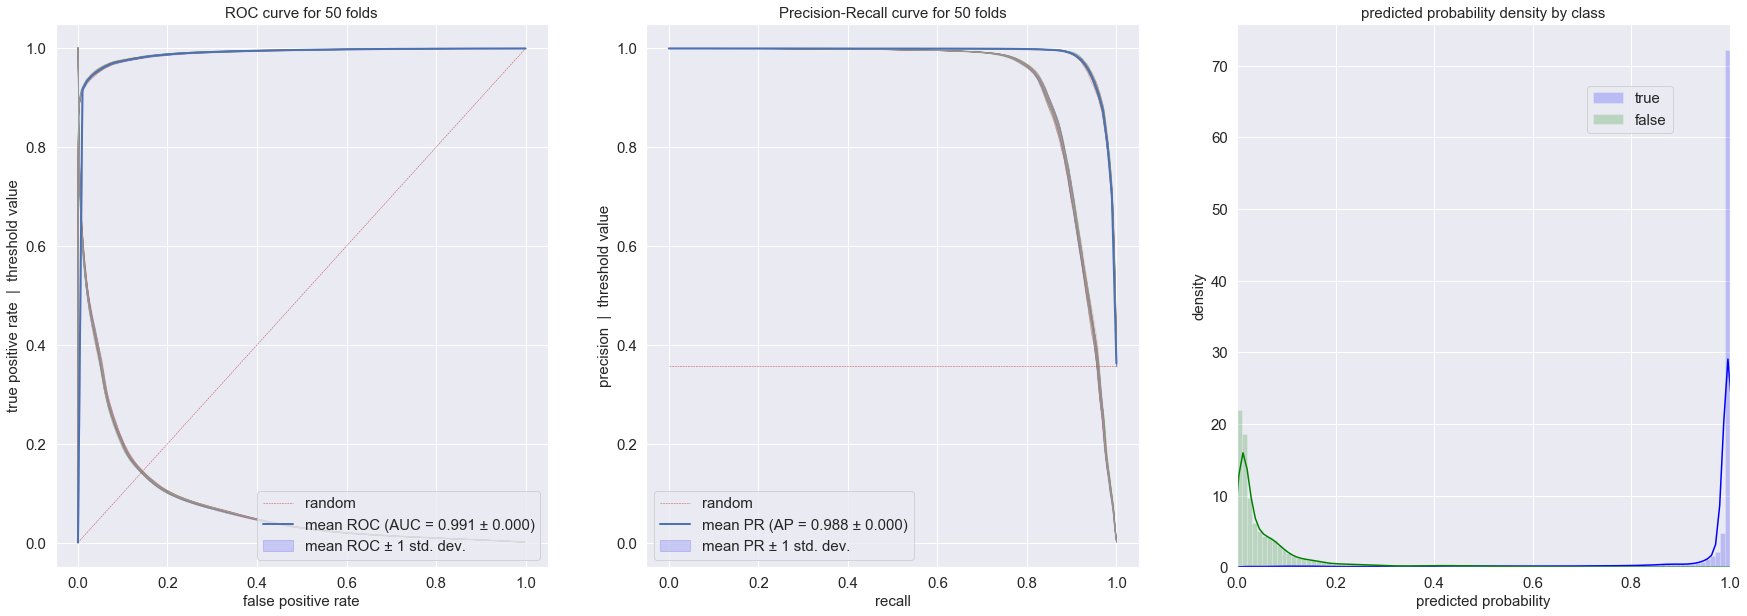

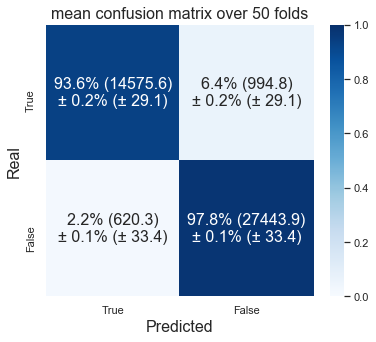

In [60]:
job_baseline.metrics.print_mean()
job_baseline.metrics.plot_threshold_decision_curves(show_folds_legend=False)
job_baseline.metrics.plot_mean_confusion_matrix()

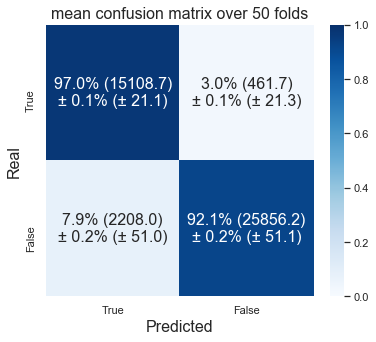

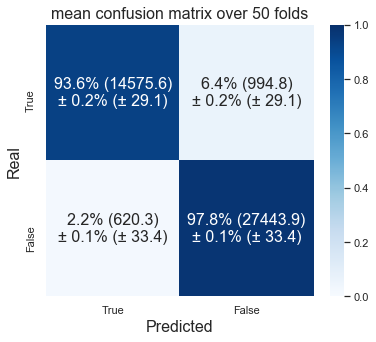

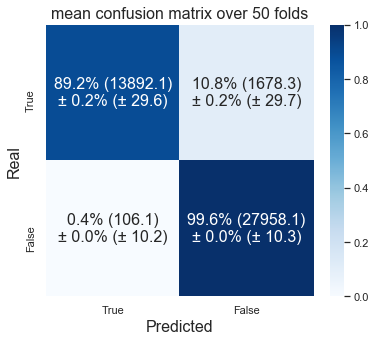

In [61]:
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.25)
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.5)
job_baseline.metrics.plot_mean_confusion_matrix(threshold=0.75)

# Removing one group

In [9]:
job_list = {}

for group in features_groups.keys():
    name = 'without_{}'.format(group)
    print_md('**{}**'.format(name))
    
    job_list[name] = Selene_Job('ferf_{}'.format(name))
    
    # get X and y
    print('Get X and y...', end= '')
    start = time.time()
    features = get_features(groups_to_remove = [group])
    X, y = data.process(features).get_X_and_y('all', 'all')
    print(' done! ({:.2f}s, {} raw features, {} features after processing)'.format(time.time() - start, len(features), X.shape[1]))
    
    # prepare job
    job_list[name].load_data(X, y, path_to_script=job_baseline.script_path)

**without_NGS**

<span style="color:red">Job < ferf_without_NGS >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (9.67s, 21 raw features, 70 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_NGS


<span style="color:green">Job < ferf_without_NGS >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_NGS


<span style="color:green">Job < ferf_without_NGS >: </span>✅ script loaded

**without_genome**

<span style="color:red">Job < ferf_without_genome >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (8.15s, 30 raw features, 52 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_genome


<span style="color:green">Job < ferf_without_genome >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_genome


<span style="color:green">Job < ferf_without_genome >: </span>✅ script loaded

**without_freq**

<span style="color:red">Job < ferf_without_freq >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (10.47s, 31 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_freq


<span style="color:green">Job < ferf_without_freq >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_freq


<span style="color:green">Job < ferf_without_freq >: </span>✅ script loaded

**without_somatic-driver**

<span style="color:red">Job < ferf_without_somatic-driver >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (10.55s, 31 raw features, 80 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_somatic-driver


<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_somatic-driver


<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ script loaded

**without_consequence**

<span style="color:red">Job < ferf_without_consequence >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (4.15s, 26 raw features, 54 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_consequence


<span style="color:green">Job < ferf_without_consequence >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_consequence


<span style="color:green">Job < ferf_without_consequence >: </span>✅ script loaded

**without_AF**

<span style="color:red">Job < ferf_without_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

Get X and y... done! (9.23s, 21 raw features, 69 features after processing)
➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_AF


<span style="color:green">Job < ferf_without_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_AF


<span style="color:green">Job < ferf_without_AF >: </span>✅ script loaded

In [62]:
job_list = {}
for group in features_groups.keys():
    name = 'without_{}'.format(group)
    job_list[name] = Selene_Job('ferf_{}'.format(name), load_from_id=True)

<span style="color:green">Job < ferf_without_NGS >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_genome >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_freq >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_consequence >: </span>✅ job found and reloaded

<span style="color:green">Job < ferf_without_AF >: </span>✅ job found and reloaded

In [11]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.run(n_jobs=25, short_job=True, memory=32)

**ferf_without_NGS**

➞ scp ssh_remote_jobs/job_ferf_without_NGS to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_NGS
script.ipy                                    100%  862    30.3KB/s   00:00    
X.pkl                                         100%   44MB  11.0MB/s   00:04    
y.pkl                                         100% 3623KB  11.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_NGS
Job <31461805> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_NGS -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_NGS >: </span>✅ submitted<br>

**ferf_without_genome**

➞ scp ssh_remote_jobs/job_ferf_without_genome to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_genome
script.ipy                                    100%  862    27.3KB/s   00:00    
X.pkl                                         100%   57MB  11.5MB/s   00:05    
y.pkl                                         100% 3623KB  10.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_genome
Job <31461806> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_genome -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_genome >: </span>✅ submitted<br>

**ferf_without_freq**

➞ scp ssh_remote_jobs/job_ferf_without_freq to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_freq
script.ipy                                    100%  862    71.9KB/s   00:00    
X.pkl                                         100%   61MB   8.7MB/s   00:07    
y.pkl                                         100% 3623KB   8.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_freq
Job <31461808> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_freq -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_freq >: </span>✅ submitted<br>

**ferf_without_somatic-driver**

➞ scp ssh_remote_jobs/job_ferf_without_somatic-driver to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_somatic-driver
script.ipy                                    100%  862    40.2KB/s   00:00    
X.pkl                                         100%   61MB  12.1MB/s   00:05    
y.pkl                                         100% 3623KB  11.6MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_somatic-driver
Job <31461810> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_somatic-driver -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ submitted<br>

**ferf_without_consequence**

➞ scp ssh_remote_jobs/job_ferf_without_consequence to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_consequence
script.ipy                                    100%  862    27.1KB/s   00:00    
X.pkl                                         100%   47MB  11.9MB/s   00:04    
y.pkl                                         100% 3623KB   9.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_consequence
Job <31461811> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_consequence -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_consequence >: </span>✅ submitted<br>

**ferf_without_AF**

➞ scp ssh_remote_jobs/job_ferf_without_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_AF
script.ipy                                    100%  862    40.1KB/s   00:00    
X.pkl                                         100%   43MB  10.8MB/s   00:04    
y.pkl                                         100% 3623KB  11.5MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_AF
Job <31461812> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_AF -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_AF >: </span>✅ submitted<br>

In [63]:
for job in job_list.values():
    print_md('**{}**'.format(job.job_id))
    job.get_results()

**ferf_without_NGS**

<span style="color:green">Job < ferf_without_NGS >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_NGS to ssh_remote_jobs/job_ferf_without_NGS
metrics.pkl                                   100%   39MB   3.5MB/s   00:11    
job_output.txt                                100% 1540    91.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**ferf_without_genome**

<span style="color:green">Job < ferf_without_genome >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_genome to ssh_remote_jobs/job_ferf_without_genome
metrics.pkl                                   100%   72MB   3.3MB/s   00:21    
job_output.txt                                100% 1550    93.3KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**ferf_without_freq**

<span style="color:green">Job < ferf_without_freq >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_freq to ssh_remote_jobs/job_ferf_without_freq
metrics.pkl                                   100%   72MB   3.8MB/s   00:18    
job_output.txt                                100% 1545    79.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**ferf_without_somatic-driver**

<span style="color:green">Job < ferf_without_somatic-driver >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_somatic-driver to ssh_remote_jobs/job_ferf_without_somatic-driver
metrics.pkl                                   100%   74MB   3.8MB/s   00:19    
job_output.txt                                100% 1575    70.2KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**ferf_without_consequence**

<span style="color:green">Job < ferf_without_consequence >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_consequence to ssh_remote_jobs/job_ferf_without_consequence
metrics.pkl                                   100%   80MB   3.2MB/s   00:25    
job_output.txt                                100% 1566    77.0KB/s   00:00    
➞ load metrics.pkl in object self.metrics


**ferf_without_AF**

<span style="color:green">Job < ferf_without_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_AF to ssh_remote_jobs/job_ferf_without_AF
metrics.pkl                                   100%   72MB   4.2MB/s   00:17    
job_output.txt                                100% 1538    83.0KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
without_NGS,0.99,0.992,0.965,0.941,0.953,0.967
without_genome,0.982,0.986,0.946,0.922,0.934,0.953
without_freq,0.988,0.991,0.959,0.936,0.947,0.963
without_somatic-driver,0.978,0.983,0.943,0.902,0.922,0.945
without_consequence,0.905,0.922,0.842,0.801,0.821,0.875
without_AF,0.986,0.989,0.955,0.933,0.944,0.961


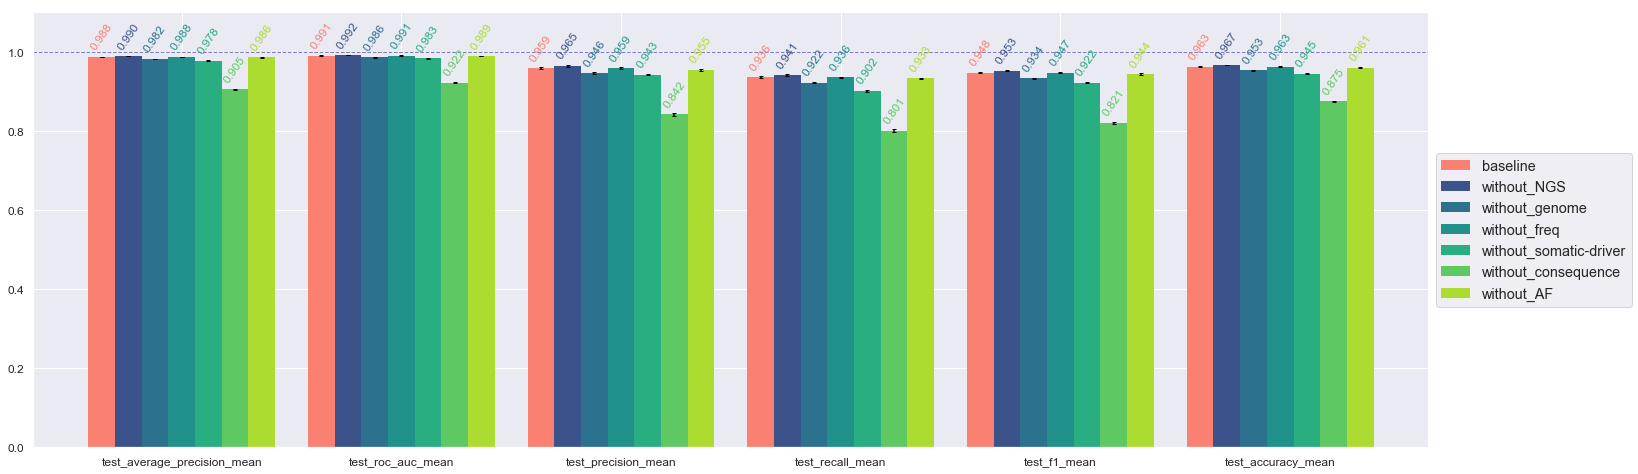

In [95]:
# create summary
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')

# fill summary
for key in job_list:
    summary.add(job_list[key].metrics, key)

# save summary
summary.save('summaries/fe_without_one_group.pkl')

# plot summary
summary.display()
summary.plot()

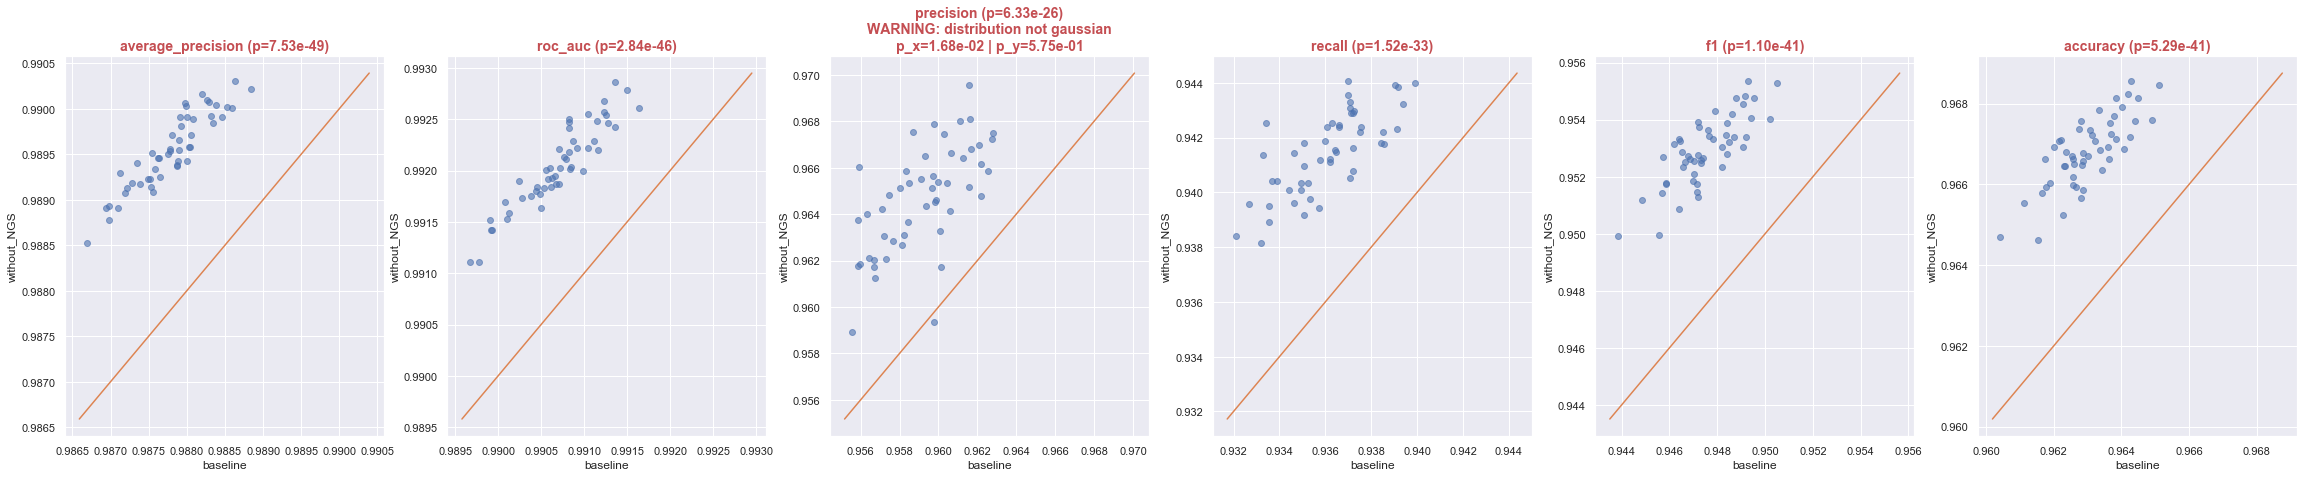

In [96]:
summary.plot_2_vs_2('baseline', 'without_NGS')

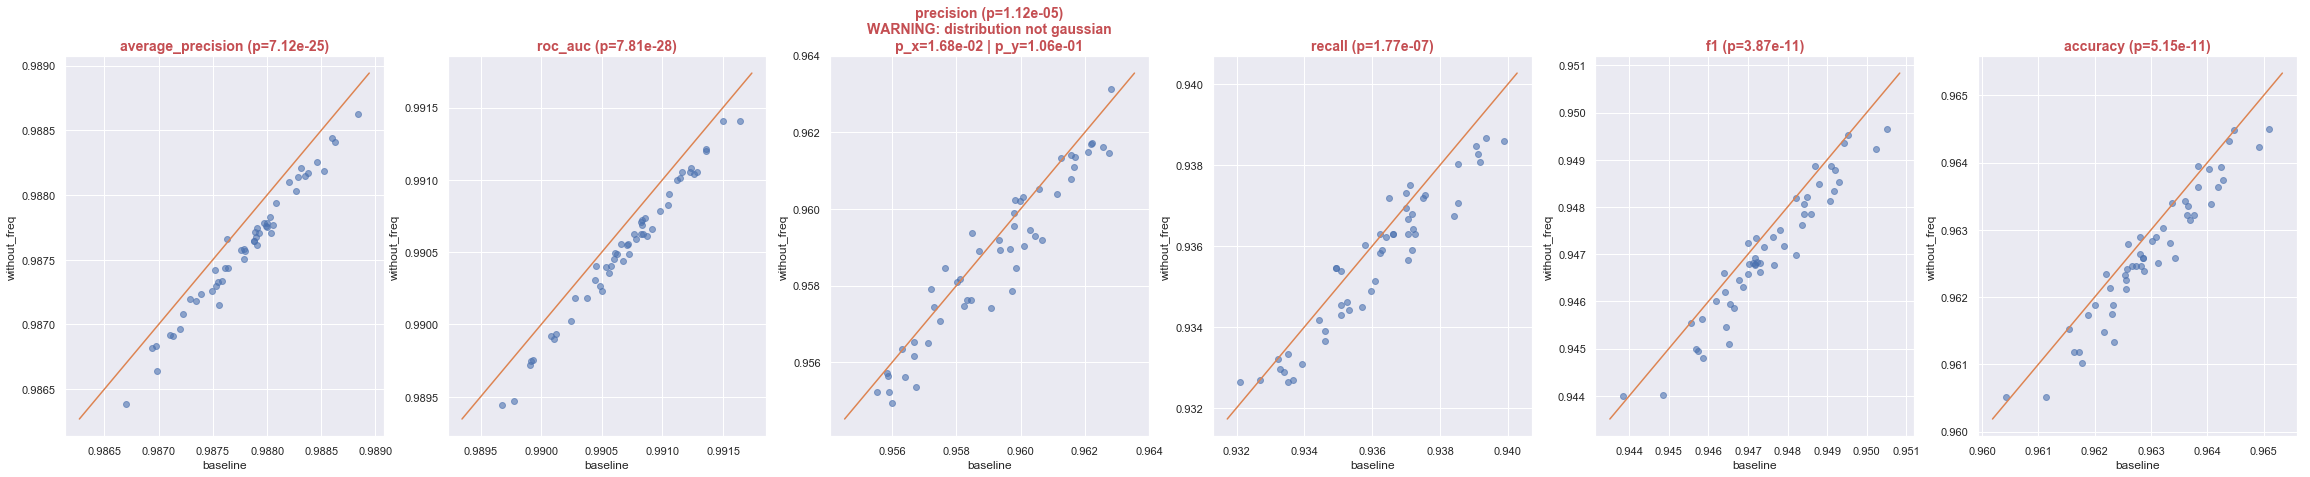

In [97]:
summary.plot_2_vs_2('baseline', 'without_freq')

# Without gnomAD populations

In [12]:
features = get_features(individual_features_to_remove = AF_populations)
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_without_gnomAD_populations')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_without_gnomAD_populations >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_without_gnomAD_populations


<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_without_gnomAD_populations


<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ script loaded

In [66]:
job = Selene_Job('ferf_without_gnomAD_populations', load_from_id=True)

<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ job found and reloaded

In [14]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_without_gnomAD_populations to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_gnomAD_populations
script.ipy                                    100%  862    47.3KB/s   00:00    
X.pkl                                         100%   51MB  16.9MB/s   00:03    
y.pkl                                         100% 3623KB  12.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_gnomAD_populations
Job <31461813> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_without_gnomAD_populations -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ submitted<br>

In [67]:
job.get_results()

<span style="color:green">Job < ferf_without_gnomAD_populations >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_without_gnomAD_populations to ssh_remote_jobs/job_ferf_without_gnomAD_populations
metrics.pkl                                   100%   72MB   4.1MB/s   00:17    
job_output.txt                                100% 1586    92.1KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
ferf_without_gnomAD_populations,0.988,0.99,0.959,0.936,0.947,0.963


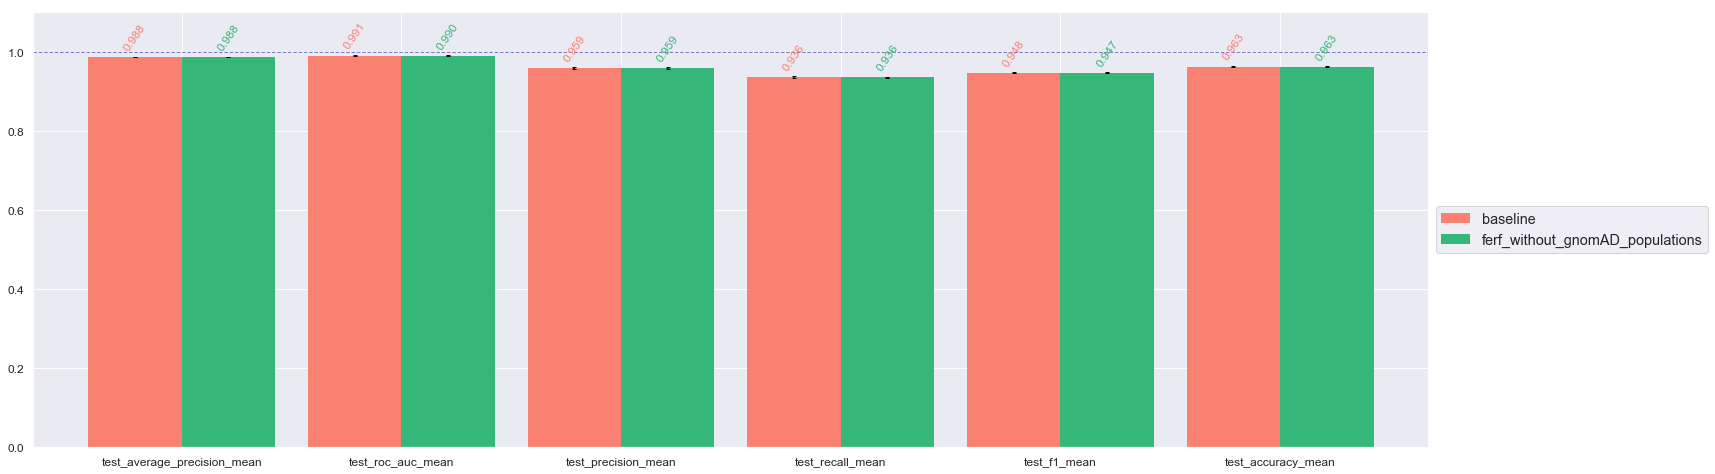

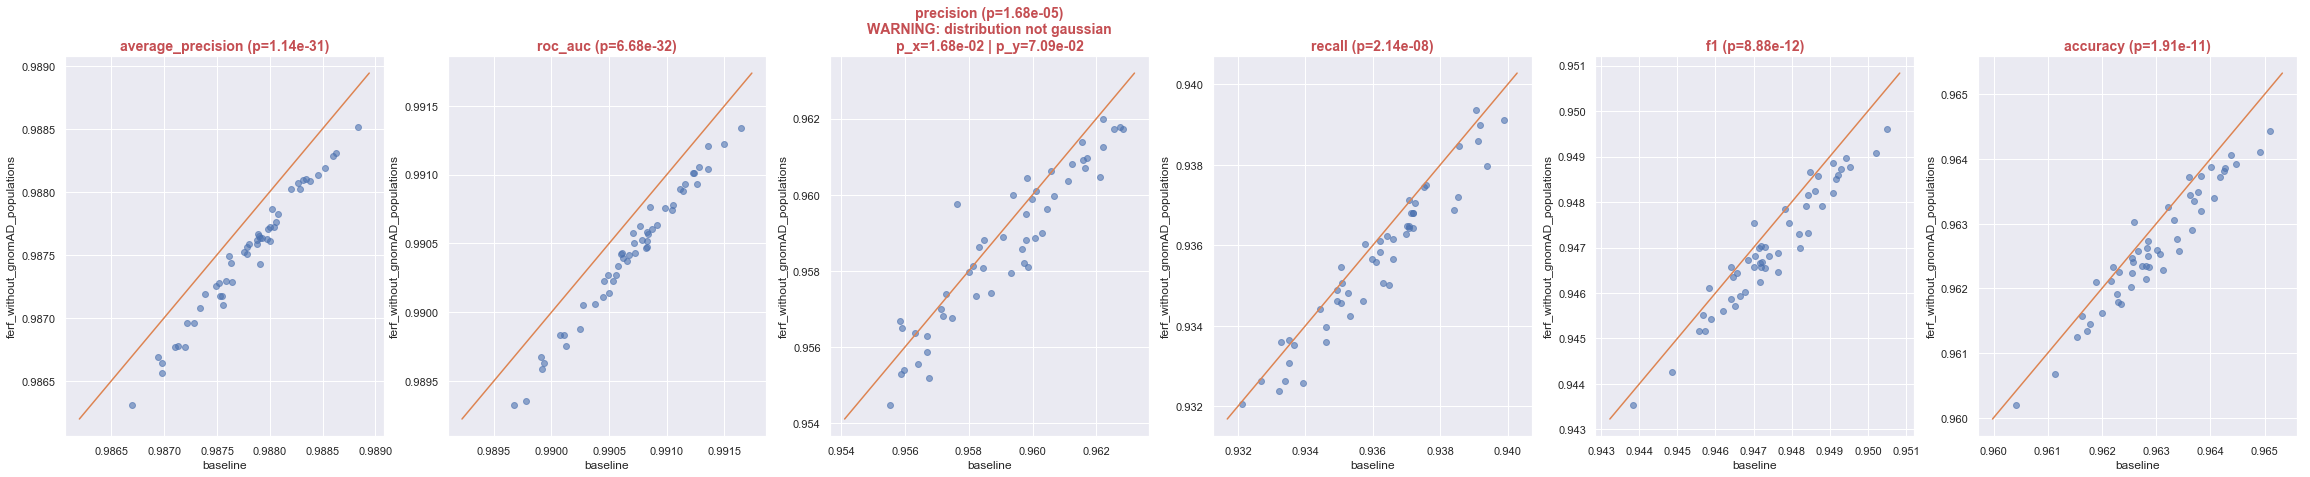

In [68]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)

summary.display()
summary.plot()
summary.plot_2_vs_2('baseline', job.job_id)

# VEP gnomAD_AF vs Pierre gnomAD_AF vs both

In [15]:
# without
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_1 = Selene_Job('fe_rf_no_gnomAD_AF')
job_1.load_data(X, y, path_to_script=job_baseline.script_path)

# VEP gnomAD_AF
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_total_AF'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_2 = Selene_Job('fe_rf_VEP_gnomAD_AF')
job_2.load_data(X, y, path_to_script=job_baseline.script_path)

# Pierre gnomAD_AF
features = get_features(individual_features_to_remove = AF_populations + ['VEP_gnomAD_AF'])
X, y = data.process(features).get_X_and_y('all', 'all')

job_3 = Selene_Job('fe_rf_Pierre_gnomAD_AF')
job_3.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < fe_rf_no_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_no_gnomAD_AF


<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_no_gnomAD_AF


<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ script loaded

<span style="color:red">Job < fe_rf_VEP_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF


<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF


<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ script loaded

<span style="color:red">Job < fe_rf_Pierre_gnomAD_AF >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF


<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF


<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ script loaded

In [69]:
job_1 = Selene_Job('fe_rf_no_gnomAD_AF'    , load_from_id=True)
job_2 = Selene_Job('fe_rf_VEP_gnomAD_AF'   , load_from_id=True)
job_3 = Selene_Job('fe_rf_Pierre_gnomAD_AF', load_from_id=True)

<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ job found and reloaded

<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ job found and reloaded

In [17]:
job_1.run(n_jobs=25, short_job=True, memory=32)
job_2.run(n_jobs=25, short_job=True, memory=32)
job_3.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_fe_rf_no_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_no_gnomAD_AF
script.ipy                                    100%  862    35.5KB/s   00:00    
X.pkl                                         100%   47MB  11.8MB/s   00:04    
y.pkl                                         100% 3623KB  11.2MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_no_gnomAD_AF
Job <31461818> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_no_gnomAD_AF -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ submitted<br>

➞ scp ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF
script.ipy                                    100%  862    42.9KB/s   00:00    
X.pkl                                         100%   49MB  12.3MB/s   00:04    
y.pkl                                         100% 3623KB  11.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF
Job <31461819> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_VEP_gnomAD_AF -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ submitted<br>

➞ scp ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF
script.ipy                                    100%  862    53.0KB/s   00:00    
X.pkl                                         100%   49MB  12.3MB/s   00:04    
y.pkl                                         100% 3623KB  10.4MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF
Job <31461820> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_Pierre_gnomAD_AF -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ submitted<br>

In [70]:
job_1.get_results()
job_2.get_results()
job_3.get_results()

<span style="color:green">Job < fe_rf_no_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_no_gnomAD_AF to ssh_remote_jobs/job_fe_rf_no_gnomAD_AF
metrics.pkl                                   100%   72MB   4.1MB/s   00:17    
job_output.txt                                100% 1547    91.6KB/s   00:00    
➞ load metrics.pkl in object self.metrics


<span style="color:green">Job < fe_rf_VEP_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF to ssh_remote_jobs/job_fe_rf_VEP_gnomAD_AF
metrics.pkl                                   100%   72MB   3.9MB/s   00:18    
job_output.txt                                100% 1551    69.3KB/s   00:00    
➞ load metrics.pkl in object self.metrics


<span style="color:green">Job < fe_rf_Pierre_gnomAD_AF >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF to ssh_remote_jobs/job_fe_rf_Pierre_gnomAD_AF
metrics.pkl                                   100%   72MB   2.7MB/s   00:27    
job_output.txt                                100% 1560    64.1KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
fe_rf_no_gnomAD_AF,0.987,0.99,0.958,0.935,0.947,0.962
fe_rf_VEP_gnomAD_AF,0.987,0.99,0.959,0.935,0.947,0.963
fe_rf_Pierre_gnomAD_AF,0.987,0.99,0.958,0.935,0.947,0.962


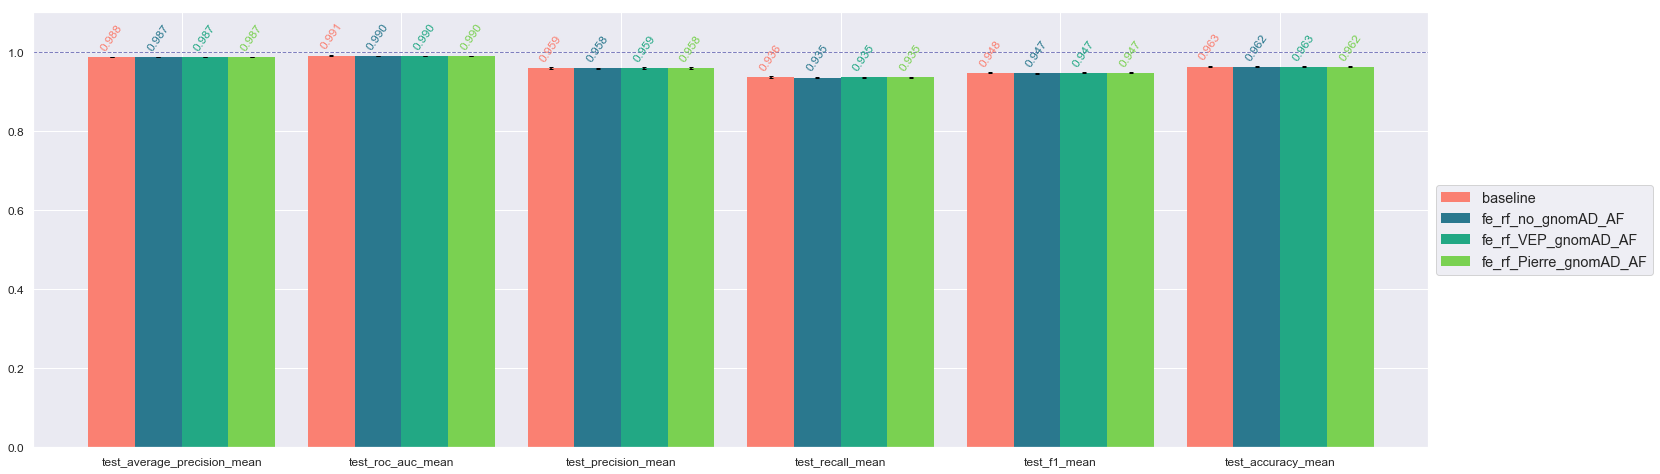

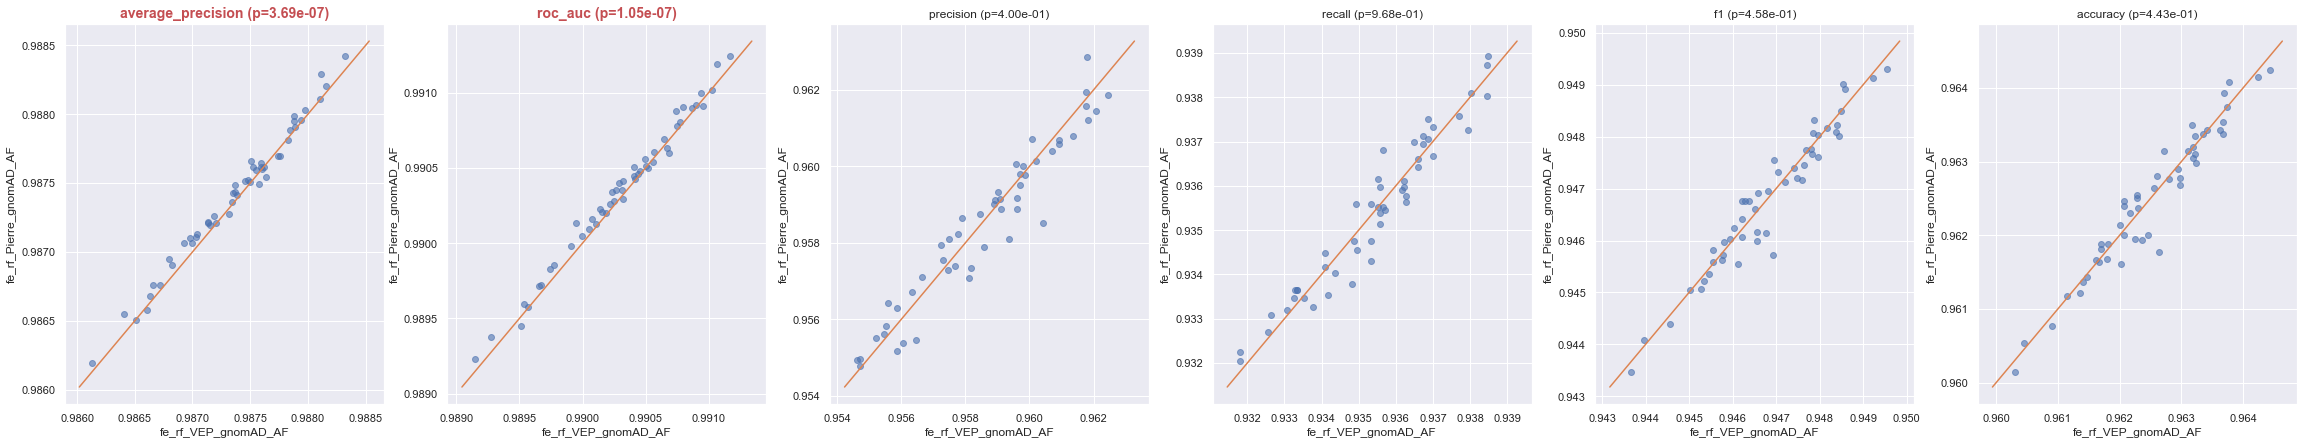

In [71]:
summary_6 = Summary()

summary_6.add(job_baseline.metrics, 'baseline', 'salmon')
summary_6.add(job_1.metrics, job_1.job_id)
summary_6.add(job_2.metrics, job_2.job_id)
summary_6.add(job_3.metrics, job_3.job_id)

summary_6.display()
summary_6.plot()
summary_6.plot_2_vs_2(job_2.job_id, job_3.job_id)

# New features

## Number of non-null gnomAD population

In [18]:
dd = data.impact.apply(lambda x: sum(x[AF_populations] != 0), axis=1).astype(int)
get_table(dd)

,count_,freq_
0,176733,81.01%
1,24487,11.22%
2,8610,3.95%
3,4623,2.12%
4,1903,0.87%
5,913,0.42%
6,535,0.25%
7,369,0.17%


In [19]:
data.add_features('VEP_gnomAD_non_null_population_number', dd, False)

In [20]:
# seaborn.countplot(x='VEP_gnomAD_non_null_population_number', hue='is_artefact', dodge=False, data=data.impact)

In [21]:
features = get_features() + ['VEP_gnomAD_non_null_population_number']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_population_number')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_population_number >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_population_number


<span style="color:green">Job < ferf_with_population_number >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_population_number


<span style="color:green">Job < ferf_with_population_number >: </span>✅ script loaded

In [72]:
job = Selene_Job('ferf_with_population_number', load_from_id=True)

<span style="color:green">Job < ferf_with_population_number >: </span>✅ job found and reloaded

In [23]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_with_population_number to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_population_number
script.ipy                                    100%  862    27.1KB/s   00:00    
X.pkl                                         100%   64MB  12.8MB/s   00:05    
y.pkl                                         100% 3623KB   9.1MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_population_number
Job <31461824> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_population_number -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_population_number >: </span>✅ submitted<br>

In [73]:
job.get_results()

<span style="color:green">Job < ferf_with_population_number >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_population_number to ssh_remote_jobs/job_ferf_with_population_number
metrics.pkl                                   100%   72MB   3.1MB/s   00:23    
job_output.txt                                100% 1575   129.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
ferf_with_population_number,0.988,0.991,0.959,0.936,0.948,0.963


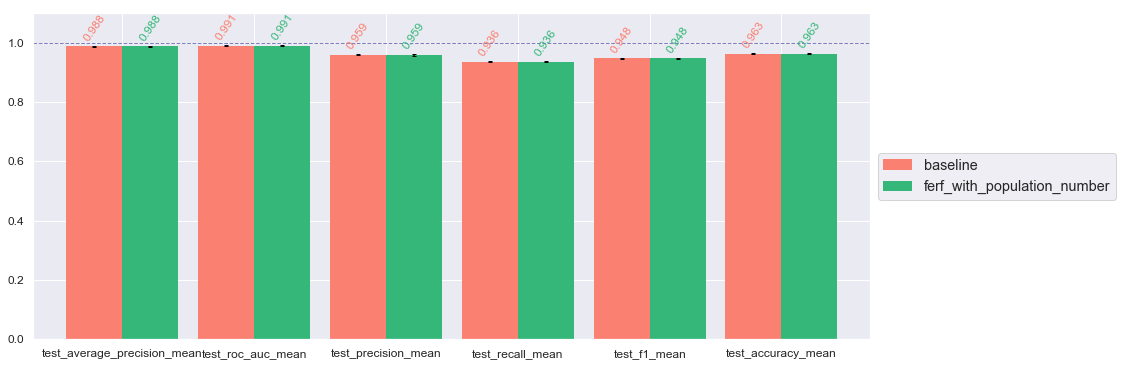

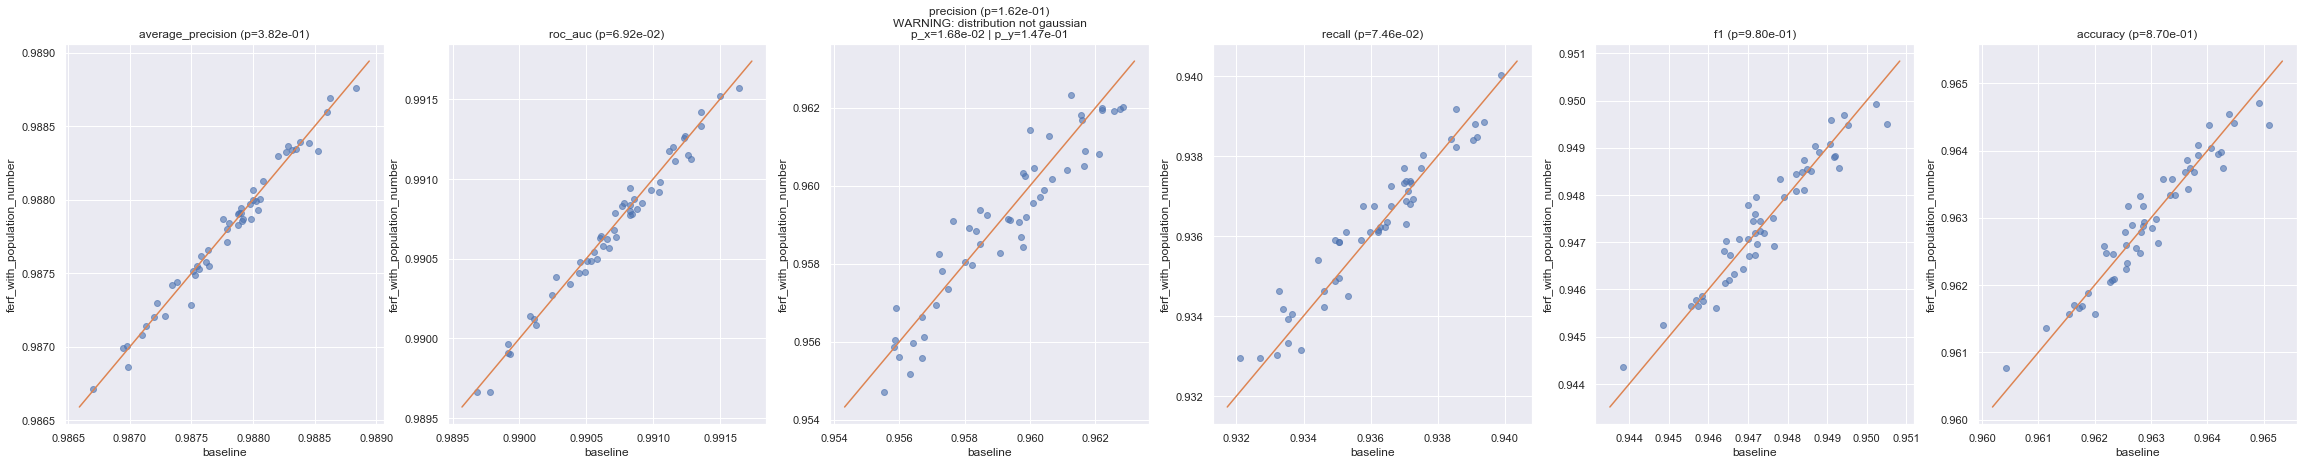

In [74]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)

summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## Strand ratio

In [24]:
dd = data.impact[['t_alt_neg_count', 't_alt_plus_count']].min(axis=1) / data.impact[['t_alt_neg_count', 't_alt_plus_count']].max(axis=1)
dd.head()

0    0.734694
1    0.791667
2    0.631579
3    0.583333
4    0.775000
dtype: float64

In [25]:
data.add_features('strand_ratio', dd, False)

In [26]:
features = get_features() + ['strand_ratio']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_strand_ratio')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_strand_ratio >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_strand_ratio


<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_strand_ratio


<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ script loaded

In [75]:
job = Selene_Job('ferf_with_strand_ratio', load_from_id=True)

<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ job found and reloaded

In [28]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_with_strand_ratio to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_strand_ratio
script.ipy                                    100%  862    33.5KB/s   00:00    
X.pkl                                         100%   64MB  12.8MB/s   00:05    
y.pkl                                         100% 3623KB  11.9MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_strand_ratio
Job <31461826> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_strand_ratio -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ submitted<br>

In [76]:
job.get_results()

<span style="color:green">Job < ferf_with_strand_ratio >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_strand_ratio to ssh_remote_jobs/job_ferf_with_strand_ratio
metrics.pkl                                   100%   72MB   3.2MB/s   00:22    
job_output.txt                                100% 1560   107.2KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
ferf_with_strand_ratio,0.988,0.991,0.959,0.936,0.947,0.963


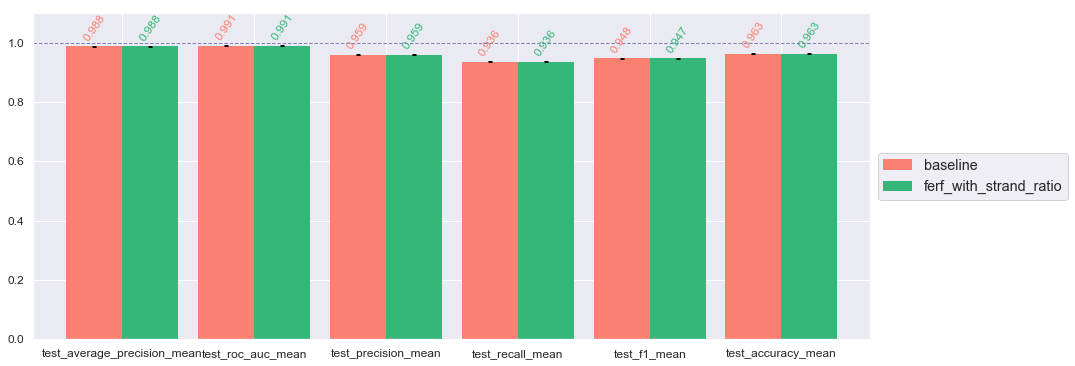

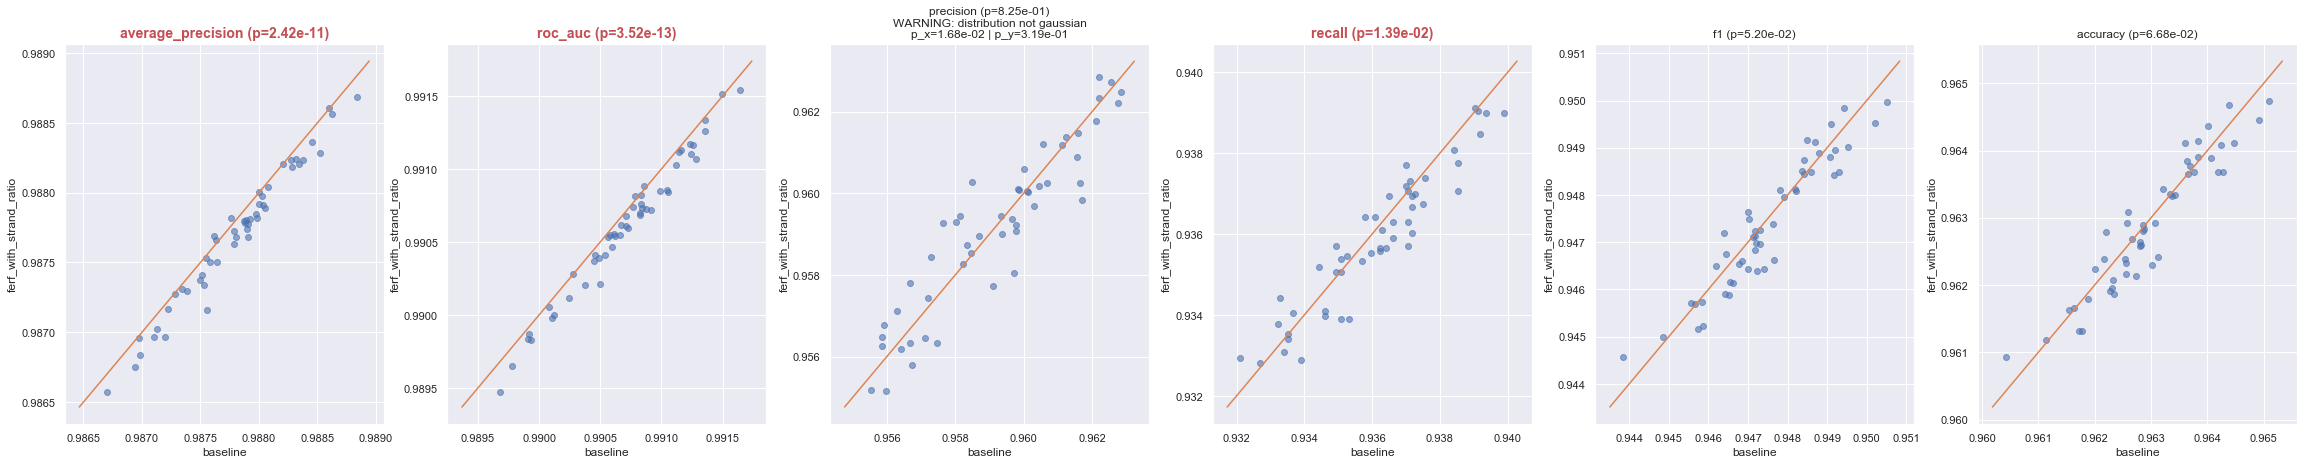

In [77]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## Event length

In [29]:
dd = abs(data.impact['Tumor_Seq_Allele2'].str.len() - data.impact['Reference_Allele'].str.len()) + 1
dd.head()

0     1
1     1
2     1
3     1
4    11
dtype: int64

In [30]:
data.add_features('event_length', dd, False)

In [31]:
features = get_features() + ['event_length']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_event_length')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_event_length >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_event_length


<span style="color:green">Job < ferf_with_event_length >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_event_length


<span style="color:green">Job < ferf_with_event_length >: </span>✅ script loaded

In [78]:
job = Selene_Job('ferf_with_event_length', load_from_id=True)

<span style="color:green">Job < ferf_with_event_length >: </span>✅ job found and reloaded

In [33]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_with_event_length to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_event_length
script.ipy                                    100%  862    21.1KB/s   00:00    
X.pkl                                         100%   64MB  12.8MB/s   00:05    
y.pkl                                         100% 3623KB  10.0MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_event_length
Job <31461828> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_event_length -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_event_length >: </span>✅ submitted<br>

In [79]:
job.get_results()

<span style="color:green">Job < ferf_with_event_length >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_event_length to ssh_remote_jobs/job_ferf_with_event_length
metrics.pkl                                   100%   72MB   3.9MB/s   00:18    
job_output.txt                                100% 1560    48.3KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
ferf_with_event_length,0.988,0.991,0.959,0.936,0.947,0.963


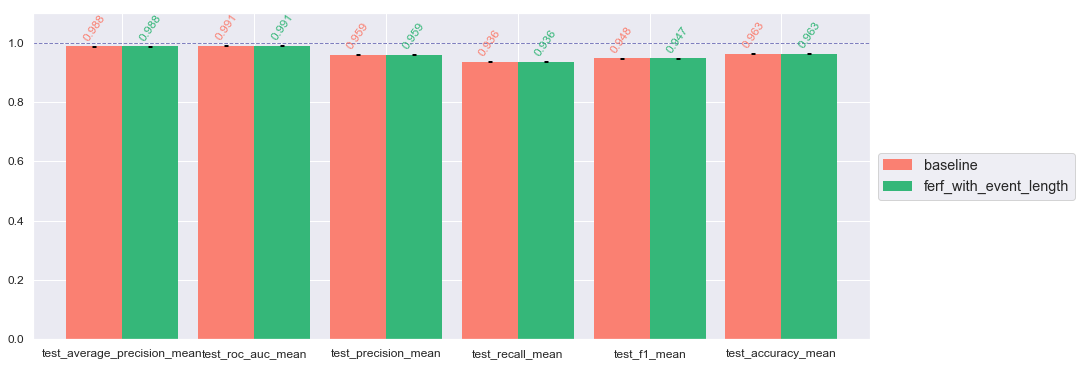

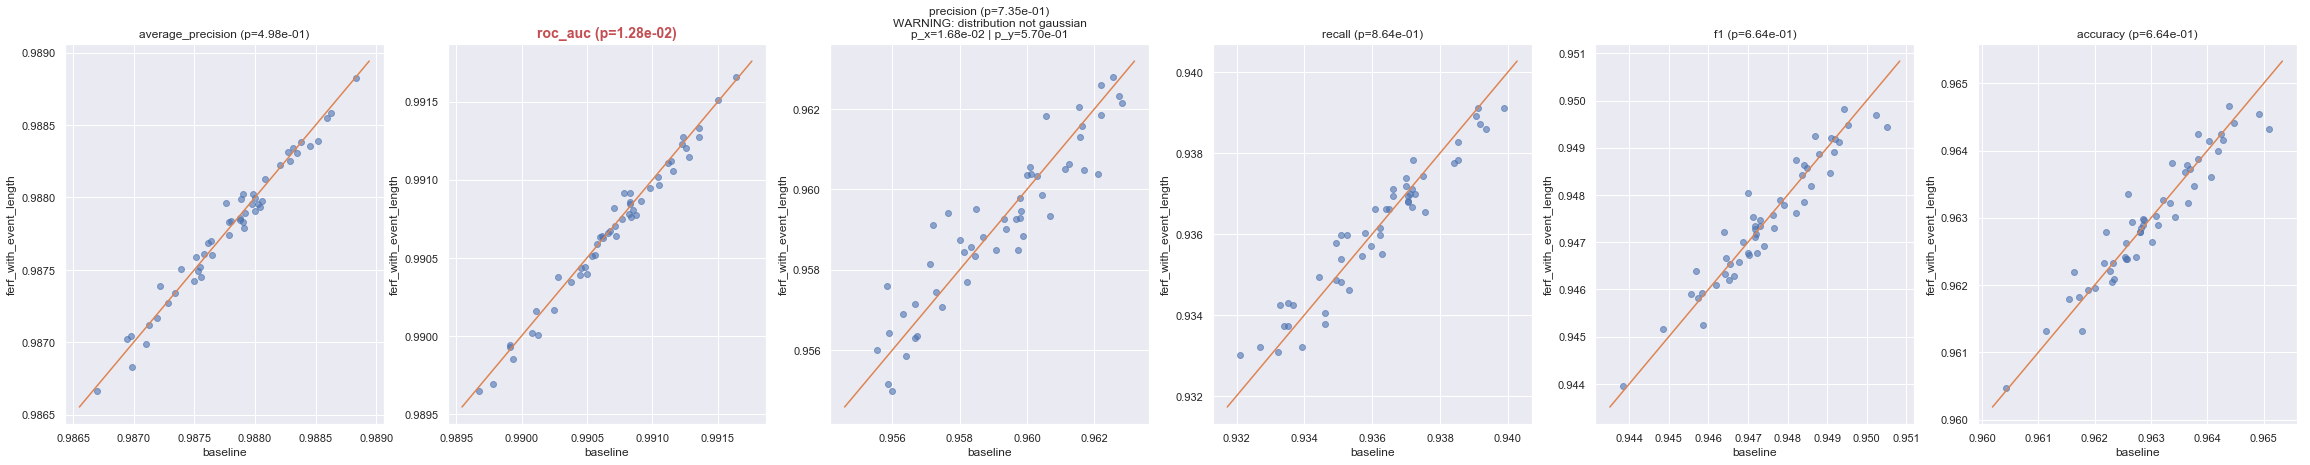

In [80]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## `variant_caller_cv`

In [34]:
features = get_features() + ['variant_caller_cv']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_variant_caller_cv')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_variant_caller_cv >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_variant_caller_cv


<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_variant_caller_cv


<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ script loaded

In [81]:
job = Selene_Job('ferf_with_variant_caller_cv', load_from_id=True)

<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ job found and reloaded

In [36]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_with_variant_caller_cv to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_variant_caller_cv
script.ipy                                    100%  862    24.6KB/s   00:00    
X.pkl                                         100%   65MB  13.0MB/s   00:05    
y.pkl                                         100% 3623KB  11.7MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_variant_caller_cv
Job <31461831> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_variant_caller_cv -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ submitted<br>

In [82]:
job.get_results()

<span style="color:green">Job < ferf_with_variant_caller_cv >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_variant_caller_cv to ssh_remote_jobs/job_ferf_with_variant_caller_cv
metrics.pkl                                   100%   72MB   3.9MB/s   00:18    
job_output.txt                                100% 1575    87.7KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
ferf_with_variant_caller_cv,0.987,0.99,0.959,0.935,0.947,0.963


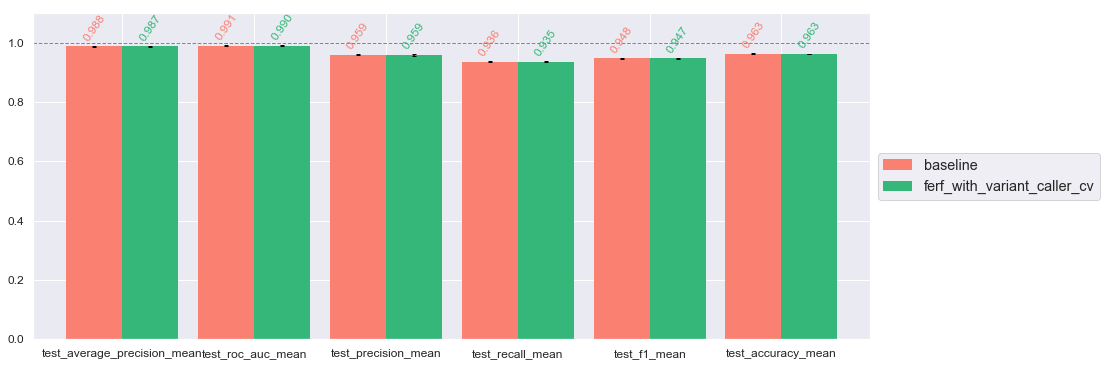

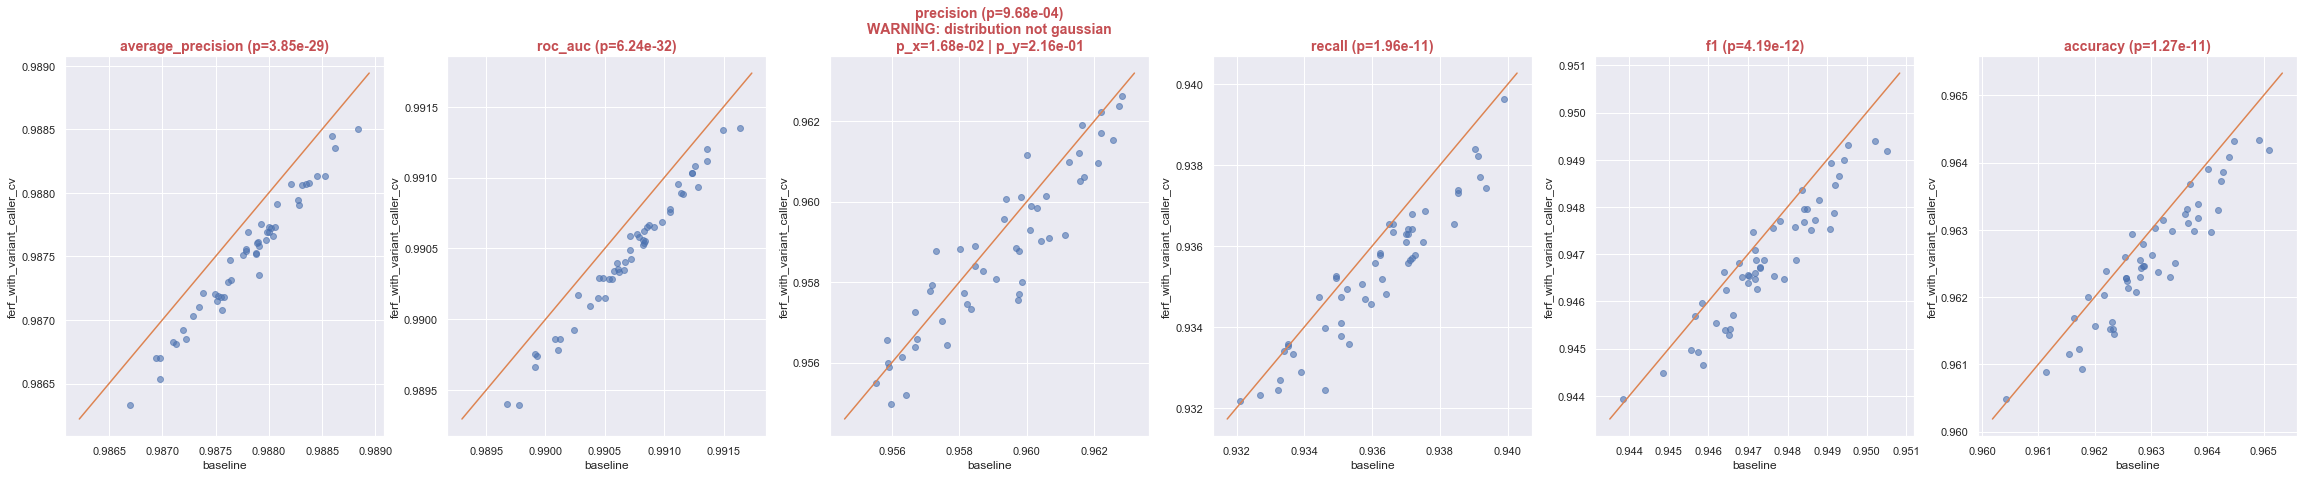

In [83]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## Base change (ex: C>T)

In [37]:
def switch_base(base):
    if base == 'G':
        return 'C'
    elif base == 'C':
        return 'G'
    elif base == 'A':
        return 'T'
    elif base == 'T':
        return 'A'

def get_base_change(mutation):
    if mutation['VEP_VARIANT_CLASS'] != 'SNV':
        return 'not_SNV'
    else:
        ref = mutation['Reference_Allele']
        alt = mutation['Tumor_Seq_Allele2']
        
        
        if mutation['Reference_Allele'] == 'G' or mutation['Reference_Allele'] == 'A' :
            ref = switch_base(ref)
            alt = switch_base(alt)
        
        return '{}>{}'.format(ref, alt)

    
dd = data.impact.apply(get_base_change, axis=1)
get_table(dd)

,count_,freq_
C>T,95322,43.69%
not_SNV,36838,16.88%
C>A,32771,15.02%
C>G,18234,8.36%
T>C,17345,7.95%
T>A,10039,4.60%
T>G,7624,3.49%


In [38]:
data.add_features('base_change', dd, True)

In [39]:
features = get_features() + ['base_change']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_base_change')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_base_change >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_base_change


<span style="color:green">Job < ferf_with_base_change >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_base_change


<span style="color:green">Job < ferf_with_base_change >: </span>✅ script loaded

In [84]:
job = Selene_Job('ferf_with_base_change', load_from_id=True)

<span style="color:green">Job < ferf_with_base_change >: </span>✅ job found and reloaded

In [41]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_with_base_change to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_base_change
script.ipy                                    100%  862    32.9KB/s   00:00    
X.pkl                                         100%   65MB  13.0MB/s   00:05    
y.pkl                                         100% 3623KB  11.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_base_change
Job <31461834> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_base_change -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_base_change >: </span>✅ submitted<br>

In [85]:
job.get_results()

<span style="color:green">Job < ferf_with_base_change >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_base_change to ssh_remote_jobs/job_ferf_with_base_change
metrics.pkl                                   100%   72MB   3.7MB/s   00:19    
job_output.txt                                100% 1557   162.3KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
ferf_with_base_change,0.988,0.991,0.96,0.937,0.948,0.964


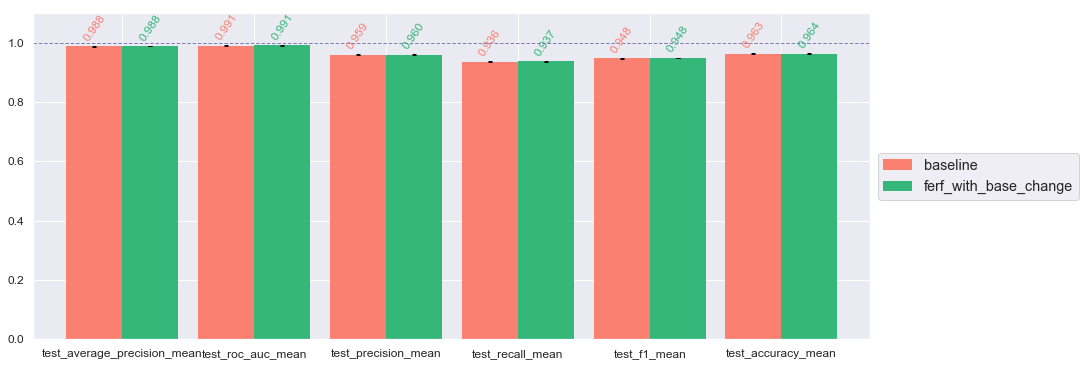

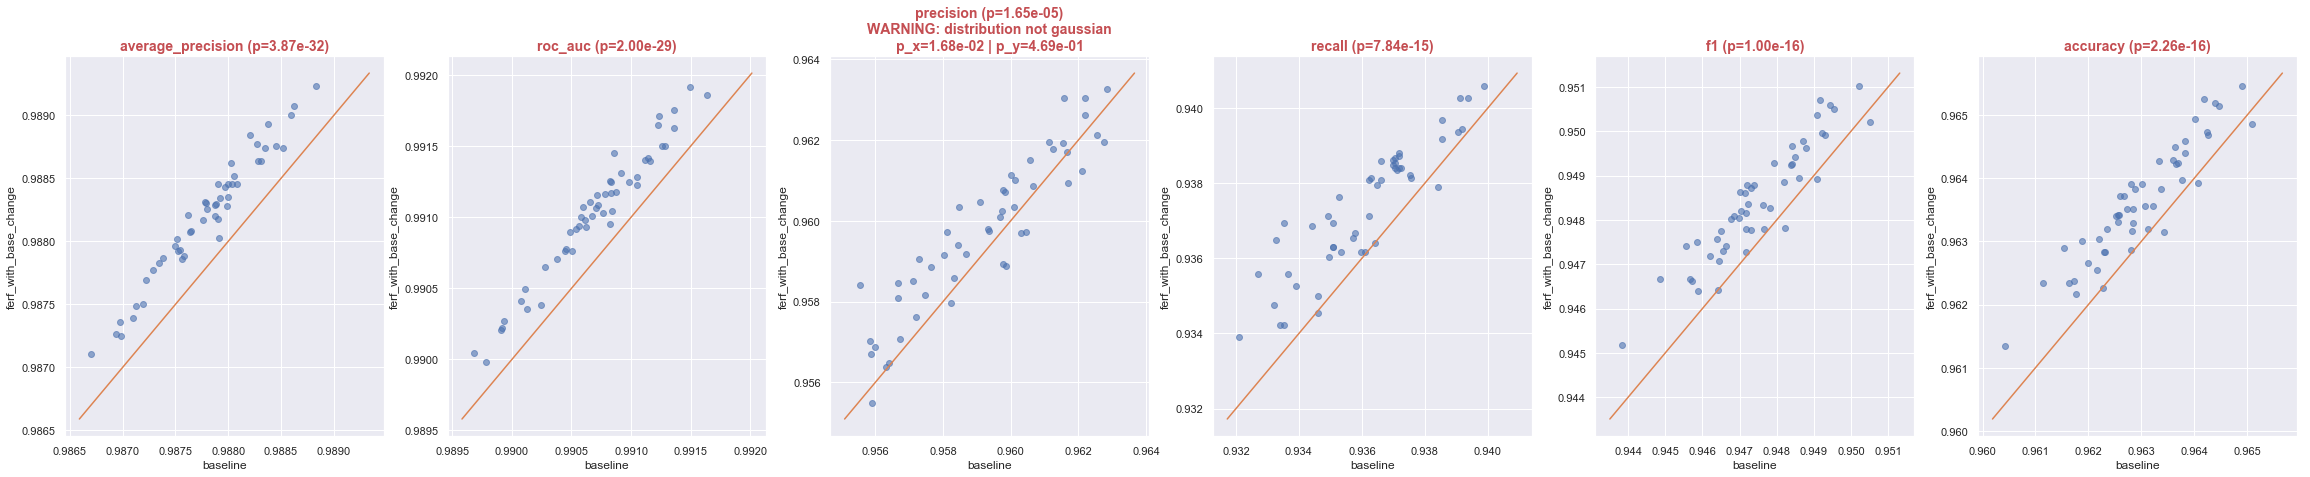

In [86]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## 3-base change (ex: ACT>AAT)

To run this part you need to download the reference fasta file from the cluster and to install pysam in your conda-env:
```bash
# get reference fasta file
$ scp guilminp@selene.mskcc.org:/ifs/work/leukgen/ref/homo_sapiens/GRCh37d5/genome/gr37.fasta temp/

# install pysam locally
$ source activate imp-ann_env
$ conda install pysam
```

In [42]:
from pysam import FastaFile
ref = FastaFile('../../../temp/gr37.fasta')

In [43]:
def switch_base(base):
    if base == 'G':
        return 'C'
    elif base == 'C':
        return 'G'
    elif base == 'A':
        return 'T'
    elif base == 'T':
        return 'A'

def get_base_at(chrom, position):
    return ref.fetch(reference = chrom, start = position - 1, end = position)

def get_3_base_change(mutation):
    if mutation['VEP_VARIANT_CLASS'] != 'SNV':
        return 'not_SNV'
    else:
        ref = mutation['Reference_Allele']
        alt = mutation['Tumor_Seq_Allele2']
        
        before = get_base_at(mutation['Chromosome'], mutation['Start_Position'] - 1)
        after  = get_base_at(mutation['Chromosome'], mutation['Start_Position'] + 1)
        if mutation['Reference_Allele'] == 'G' or mutation['Reference_Allele'] == 'A' :
            ref    = switch_base(ref)
            alt    = switch_base(alt)
            before = switch_base(before)
            after  = switch_base(after)
        
        return '{2}{0}{3}>{2}{1}{3}'.format(ref, alt, before, after)

In [44]:
dd = data.impact.apply(get_3_base_change, axis=1)
get_table(dd).head()
len(dd.unique()) # 96 + 1 for 'not_SNV'
len(get_table(dd).index) - 1

96

In [45]:
base_change_3_table = get_table(dd)
base_change_3_table = base_change_3_table[base_change_3_table['count_'] >= 2000]

def get_reduced_base_change_3(base_change_3):
    if base_change_3 in base_change_3_table.index:
        return base_change_3
    else:
        return 'other'

In [46]:
dd = dd.apply(get_reduced_base_change_3)
len(dd.unique())

26

In [47]:
data.add_features('3_base_change', dd, True)

In [48]:
data.impact[['Chromosome', 'Start_Position', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2', '3_base_change']].head(6)

,Chromosome,Start_Position,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,3_base_change
0,4,106164779,SNP,G,A,GCT>GTT
1,19,2220185,SNP,G,T,other
2,7,128829128,SNP,G,A,GCC>GTC
3,9,87570204,SNP,C,G,other
4,3,142281824,INS,-,GCAGGACTCTT,not_SNV
5,2,220440222,SNP,C,A,TCT>TAT


In [49]:
features = get_features() + ['3_base_change']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('fe_rf_with_3_base_change')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < fe_rf_with_3_base_change >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_fe_rf_with_3_base_change


<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_fe_rf_with_3_base_change


<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ script loaded

In [87]:
job = Selene_Job('fe_rf_with_3_base_change', load_from_id=True)

<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ job found and reloaded

In [51]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_fe_rf_with_3_base_change to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_with_3_base_change
script.ipy                                    100%  862     3.3KB/s   00:00    
X.pkl                                         100%   65MB  13.0MB/s   00:05    
y.pkl                                         100% 3623KB  13.5MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_with_3_base_change
Job <31461837> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J fe_rf_with_3_base_change -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ submitted<br>

In [88]:
job.get_results()

<span style="color:green">Job < fe_rf_with_3_base_change >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_fe_rf_with_3_base_change to ssh_remote_jobs/job_fe_rf_with_3_base_change
metrics.pkl                                   100%   72MB   3.5MB/s   00:20    
job_output.txt                                100% 1566    88.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
fe_rf_with_3_base_change,0.988,0.991,0.96,0.938,0.949,0.964


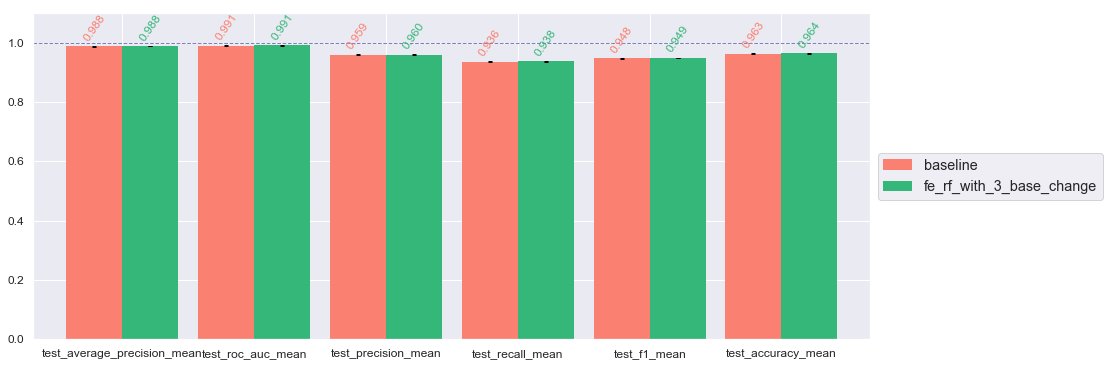

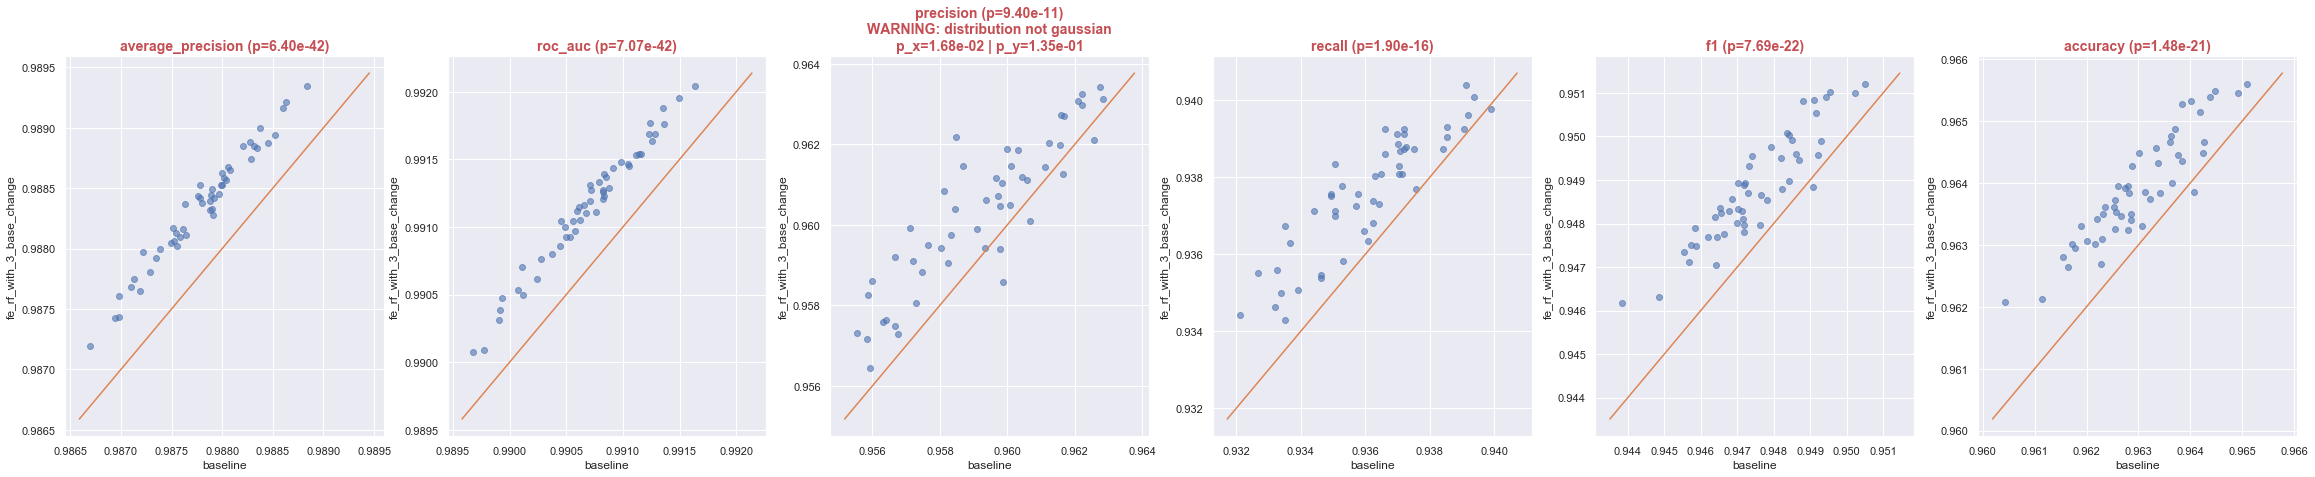

In [89]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

## `VEP_SYMBOL`

In [52]:
gene_table = get_table(data.impact['VEP_SYMBOL'])
gene_table = gene_table[gene_table['count_'] >= 1000]

def get_reduced_gene(gene):
    if gene in gene_table.index:
        return gene
    else:
        return 'other'

dd = data.impact['VEP_SYMBOL'].apply(get_reduced_gene)
get_table(dd)

,count_,freq_
other,140214,64.27%
TP53,12921,5.92%
KRAS,4558,2.09%
PIK3CA,4443,2.04%
APC,4188,1.92%
KMT2D,3097,1.42%
ARID1A,2967,1.36%
PTEN,2415,1.11%
KMT2C,2147,0.98%
NF1,2029,0.93%


In [53]:
data.add_features('reduced_gene', dd, True)

In [54]:
features = get_features() + ['reduced_gene']
X, y = data.process(features).get_X_and_y('all', 'all')

job = Selene_Job('ferf_with_reduced_gene')
job.load_data(X, y, path_to_script=job_baseline.script_path)

<span style="color:red">Job < ferf_with_reduced_gene >: </span>⚠️ job already exists, please remove it with `job.remove()` or use `load_from_id = True` to reload the existing job<br>

➞ save X.pkl & y.pkl in ssh_remote_jobs/job_ferf_with_reduced_gene


<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ data loaded

➞ cp script.ipy from ssh_remote_jobs/job_ferf_baseline/script.ipy to ssh_remote_jobs/job_ferf_with_reduced_gene


<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ script loaded

In [90]:
job = Selene_Job('ferf_with_reduced_gene', load_from_id=True)

<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ job found and reloaded

In [57]:
job.run(n_jobs=25, short_job=True, memory=32)

➞ scp ssh_remote_jobs/job_ferf_with_reduced_gene to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_reduced_gene
script.ipy                                    100%  862     0.8KB/s   00:01    
X.pkl                                         100%   65MB  13.0MB/s   00:05    
y.pkl                                         100% 3623KB  10.3MB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on imp-ann_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_reduced_gene
Job <31461840> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J ferf_with_reduced_gene -We 59 -n 25 -R "span[ptile=5,mem=32]" "ipython script.ipy"


<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ submitted<br>

In [91]:
job.get_results()

<span style="color:green">Job < ferf_with_reduced_gene >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator_v2/analysis/prediction/driver_classification/ssh_remote_jobs/job_ferf_with_reduced_gene to ssh_remote_jobs/job_ferf_with_reduced_gene
metrics.pkl                                   100%   71MB   4.2MB/s   00:16    
job_output.txt                                100% 1560    61.4KB/s   00:00    
➞ load metrics.pkl in object self.metrics


,test_average_precision_mean,test_roc_auc_mean,test_precision_mean,test_recall_mean,test_f1_mean,test_accuracy_mean
metrics_name,,,,,,
baseline,0.988,0.991,0.959,0.936,0.948,0.963
ferf_with_reduced_gene,0.989,0.992,0.963,0.94,0.951,0.966


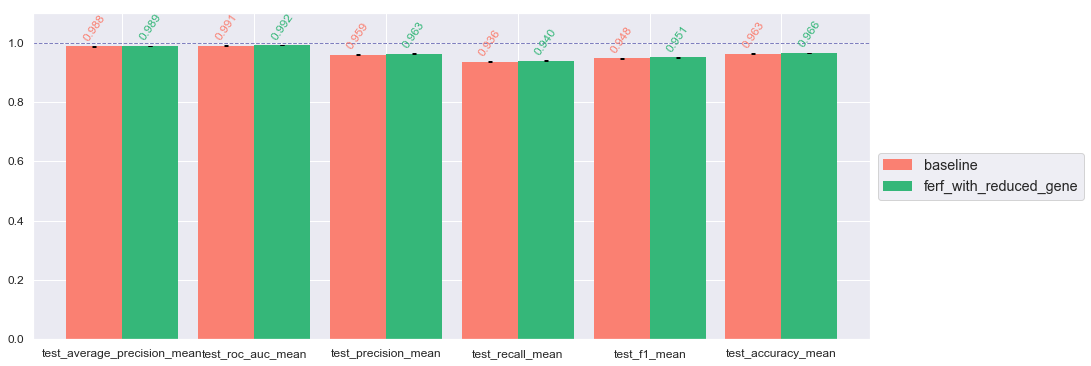

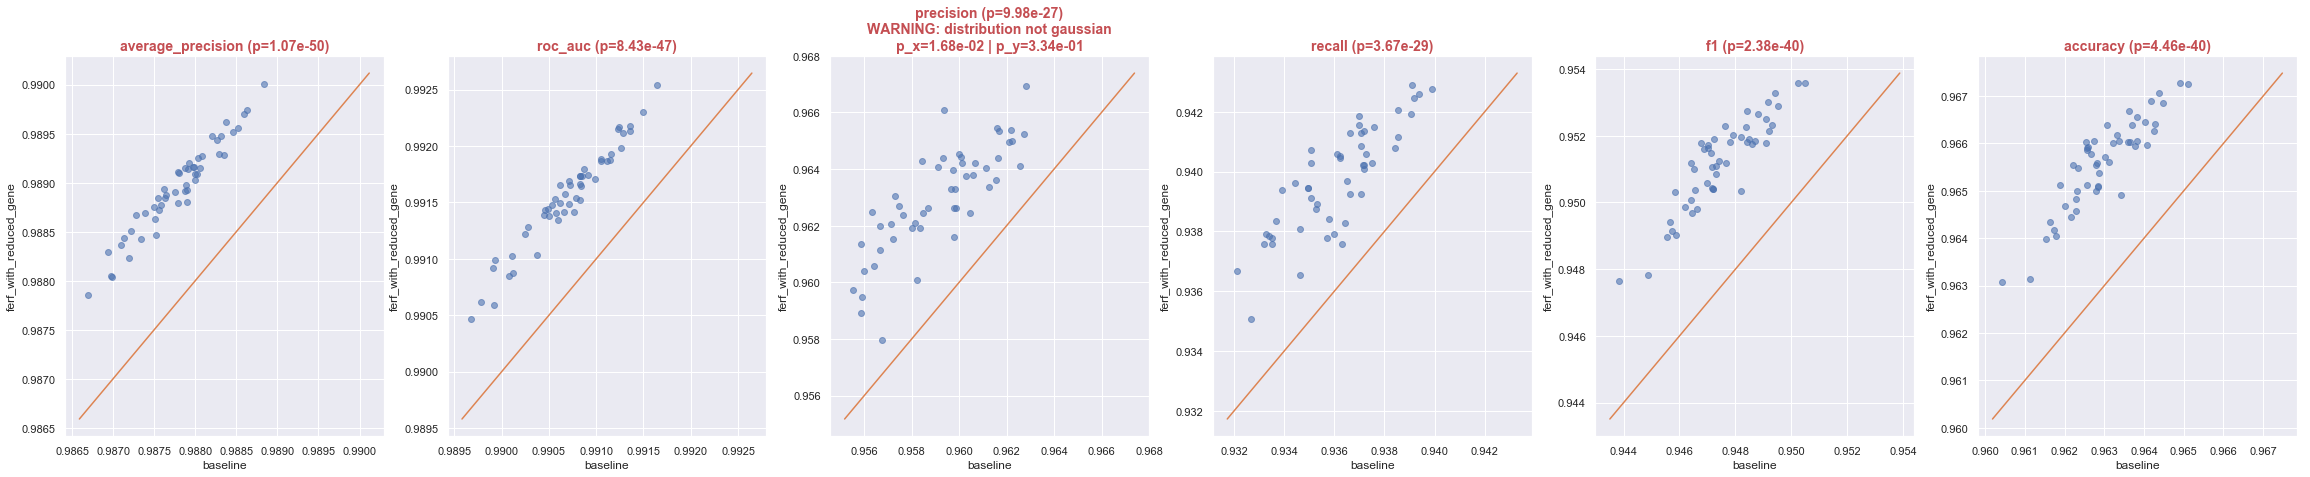

In [92]:
summary = Summary()
summary.add(job_baseline.metrics, 'baseline', 'salmon')
summary.add(job.metrics, job.job_id)
summary.display()
summary.plot(figsize=(15, 6))
summary.plot_2_vs_2('baseline', job.job_id)

# Conclusion

In [ ]:
features_groups = {
    'NGS': ['t_depth', 't_vaf', 't_alt_count',
            'n_depth', 'n_vaf', 'n_alt_count',
            't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
            'sample_coverage'],

    'genome': ['Chromosome', 'VEP_VARIANT_CLASS'],

    'freq': ['frequency_in_normals'],

    'somatic-driver': ['VEP_COSMIC_CNT'],

    'consequence': ['gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG',
                    'VEP_SIFT_class', 'VEP_PolyPhen_class'],

    'AF': ['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
           'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH',
           'VEP_in_dbSNP'],
}

AF_populations = ['VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN', 'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH']

    
def get_features(groups_to_remove = [], individual_features_to_remove=[]):

    final_selection = unlist([group for key, group in features_groups.items() if key not in groups_to_remove])
    final_selection = [f for f in final_selection if f not in individual_features_to_remove]
    
    # remove redundant values
    return list(set(final_selection))

The optimal set of features is:

- genome:
    - `Chromosome`
    - `VEP_VARIANT_CLASS`


- freq:
    - `frequency_in_normals`


- somatic-driver:
    - `VEP_COSMIC_CNT`


- consequence:
    - `gene_type`
    - `VEP_Consequence`
    - `VEP_IMPACT`
    - `VEP_CLIN_SIG`
    - `VEP_SIFT_class`
    - `VEP_PolyPhen_class`


- AF:
    - `VEP_gnomAD_AF`
    - `VEP_in_dbSNP`


- new features:
    - `base_change`
    - `reduced_VEP_SYMBOL`
    
    
⚠️ For the sake of simplicity the 3-base change feature wasn't incorporated but it has proven to be better than a simple base-change feature.

The following function adds the three new features to an `ImpactWrapper` object and return the optimal list of features:

In [98]:
def add_optimal_features_driver_classification(data):
    """
    Compute the optimal set of features from the end of `feature_engineering.ipynb` and return the optimal list of features.
    → Arguments:
        - data: an ImpactWrapper object
    """
    # base_change
    def switch_base(base):
        if base == 'G':
            return 'C'
        elif base == 'C':
            return 'G'
        elif base == 'A':
            return 'T'
        elif base == 'T':
            return 'A'

    def get_base_change(mutation):
        if mutation['VEP_VARIANT_CLASS'] != 'SNV':
            return 'not_SNV'
        else:
            ref = mutation['Reference_Allele']
            alt = mutation['Tumor_Seq_Allele2']

            if mutation['Reference_Allele'] == 'G' or mutation['Reference_Allele'] == 'A' :
                ref = switch_base(ref)
                alt = switch_base(alt)

            return '{}>{}'.format(ref, alt)

    dd = data.impact.apply(get_base_change, axis=1)
    data.add_features('base_change', dd, True)
    
    
    # reduced_VEP_SYMBOL
    gene_table = get_table(data.impact['VEP_SYMBOL'])
    gene_table = gene_table[gene_table['count_'] >= 1000]

    def get_reduced_gene(gene):
        if gene in gene_table.index:
            return gene
        else:
            return 'other'

    dd = data.impact['VEP_SYMBOL'].apply(get_reduced_gene)
    data.add_features('reduced_VEP_SYMBOL', dd, True)
    
    
    # features list
    features = [

        # genome
        'Chromosome', 'VEP_VARIANT_CLASS',

        # freq
        'frequency_in_normals',

        # somatic-driver
        'VEP_COSMIC_CNT',

        # consequence
        'gene_type', 'VEP_Consequence', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_SIFT_class', 'VEP_PolyPhen_class',

        # AF
        'VEP_gnomAD_AF', 'VEP_in_dbSNP',

        # new features
        'base_change', 'reduced_VEP_SYMBOL'
    ]
    
    return (features)

In [100]:
data = Impact_Wrapper('../../../data/processed/annotated_final_IMPACT_mutations_20181105.txt', 'is_driver')

features = add_optimal_features_driver_classification(data)
print(len(features))

X, y = data.process(features).get_X_and_y('all', 'all')
Impact_Wrapper.print_info(X, y)

14
X: (218173, 114) | y: (218173,)


,count_,freq_
False,140321,64.32%
True,77852,35.68%


Fit model... done! (67.95s)


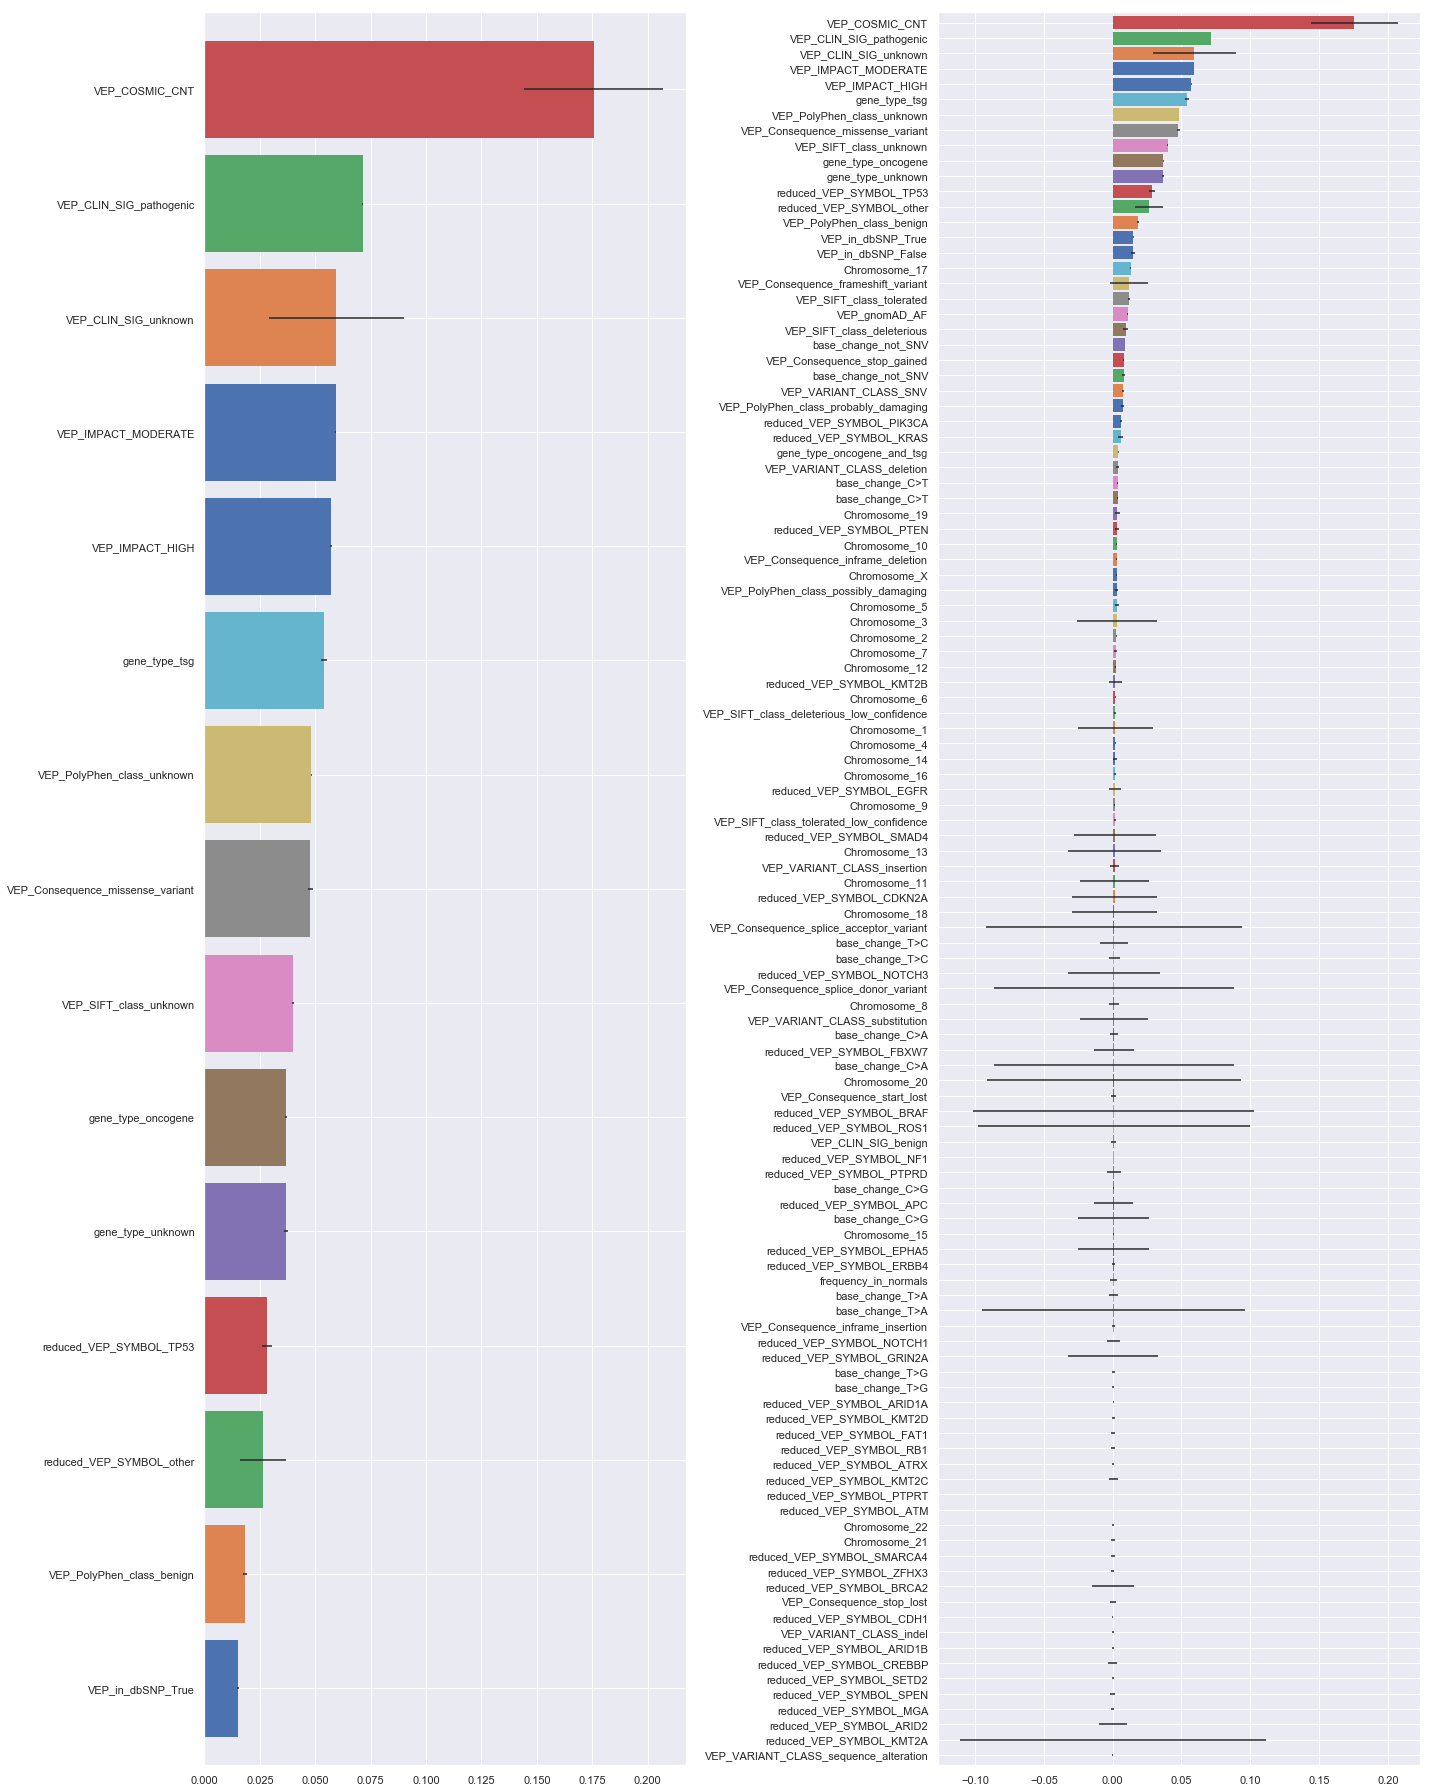

In [101]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model_bestRF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                             RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=20, criterion='entropy', n_jobs=5))

metrics = Metrics(model_bestRF, X, y, cv_strategy, n_jobs=5, run_model=False)
metrics.plot_features_importance(random_forest=True, pipeline_step_index=1, figsize=(20, 25))

In [104]:
X.head()

,frequency_in_normals,VEP_COSMIC_CNT,VEP_gnomAD_AF,Chromosome_1,Chromosome_10,Chromosome_11,Chromosome_12,Chromosome_13,Chromosome_14,Chromosome_15,Chromosome_16,Chromosome_17,Chromosome_18,Chromosome_19,Chromosome_2,Chromosome_20,Chromosome_21,Chromosome_22,Chromosome_3,Chromosome_4,Chromosome_5,Chromosome_6,Chromosome_7,Chromosome_8,Chromosome_9,Chromosome_X,VEP_Consequence_frameshift_variant,VEP_Consequence_inframe_deletion,VEP_Consequence_inframe_insertion,VEP_Consequence_missense_variant,VEP_Consequence_splice_acceptor_variant,VEP_Consequence_splice_donor_variant,VEP_Consequence_start_lost,VEP_Consequence_stop_gained,VEP_Consequence_stop_lost,VEP_VARIANT_CLASS_SNV,VEP_VARIANT_CLASS_deletion,VEP_VARIANT_CLASS_indel,VEP_VARIANT_CLASS_insertion,VEP_VARIANT_CLASS_sequence_alteration,VEP_VARIANT_CLASS_substitution,VEP_IMPACT_HIGH,VEP_IMPACT_MODERATE,VEP_CLIN_SIG_benign,VEP_CLIN_SIG_pathogenic,VEP_CLIN_SIG_unknown,VEP_SIFT_class_deleterious,VEP_SIFT_class_deleterious_low_confidence,VEP_SIFT_class_tolerated,VEP_SIFT_class_tolerated_low_confidence,VEP_SIFT_class_unknown,VEP_PolyPhen_class_benign,VEP_PolyPhen_class_possibly_damaging,VEP_PolyPhen_class_probably_damaging,VEP_PolyPhen_class_unknown,VEP_in_dbSNP_False,VEP_in_dbSNP_True,gene_type_oncogene,gene_type_oncogene_and_tsg,gene_type_tsg,gene_type_unknown,base_change_C>A,base_change_C>G,base_change_C>T,base_change_T>A,base_change_T>C,base_change_T>G,base_change_not_SNV,base_change_C>A,base_change_C>G,base_change_C>T,base_change_T>A,base_change_T>C,base_change_T>G,base_change_not_SNV,reduced_VEP_SYMBOL_APC,reduced_VEP_SYMBOL_ARID1A,reduced_VEP_SYMBOL_ARID1B,reduced_VEP_SYMBOL_ARID2,reduced_VEP_SYMBOL_ATM,reduced_VEP_SYMBOL_ATRX,reduced_VEP_SYMBOL_BRAF,reduced_VEP_SYMBOL_BRCA2,reduced_VEP_SYMBOL_CDH1,reduced_VEP_SYMBOL_CDKN2A,reduced_VEP_SYMBOL_CREBBP,reduced_VEP_SYMBOL_EGFR,reduced_VEP_SYMBOL_EPHA5,reduced_VEP_SYMBOL_ERBB4,reduced_VEP_SYMBOL_FAT1,reduced_VEP_SYMBOL_FBXW7,reduced_VEP_SYMBOL_GRIN2A,reduced_VEP_SYMBOL_KMT2A,reduced_VEP_SYMBOL_KMT2B,reduced_VEP_SYMBOL_KMT2C,reduced_VEP_SYMBOL_KMT2D,reduced_VEP_SYMBOL_KRAS,reduced_VEP_SYMBOL_MGA,reduced_VEP_SYMBOL_NF1,reduced_VEP_SYMBOL_NOTCH1,reduced_VEP_SYMBOL_NOTCH3,reduced_VEP_SYMBOL_PIK3CA,reduced_VEP_SYMBOL_PTEN,reduced_VEP_SYMBOL_PTPRD,reduced_VEP_SYMBOL_PTPRT,reduced_VEP_SYMBOL_RB1,reduced_VEP_SYMBOL_ROS1,reduced_VEP_SYMBOL_SETD2,reduced_VEP_SYMBOL_SMAD4,reduced_VEP_SYMBOL_SMARCA4,reduced_VEP_SYMBOL_SPEN,reduced_VEP_SYMBOL_TP53,reduced_VEP_SYMBOL_ZFHX3,reduced_VEP_SYMBOL_other
212235,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
83144,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149545,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [107]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier

model_bestRF = make_pipeline(RandomUnderSampler(ratio='majority', random_state=42),
                             RandomForestClassifier(random_state=42, n_estimators=500, max_depth=20, criterion='entropy', n_jobs=5))

metrics = Metrics(model_bestRF, X, y, cv_strategy, n_jobs=5)

Run model... done! (350.06s)


In [108]:
metrics.print_mean()

▴ Mean average_precision: 0.991 ± 0.000
▴ Mean roc_auc          : 0.993 ± 0.000
▴ Mean precision        : 0.967 ± 0.001
▴ Mean recall           : 0.946 ± 0.001
▴ Mean f1               : 0.956 ± 0.001
▴ Mean accuracy         : 0.969 ± 0.001


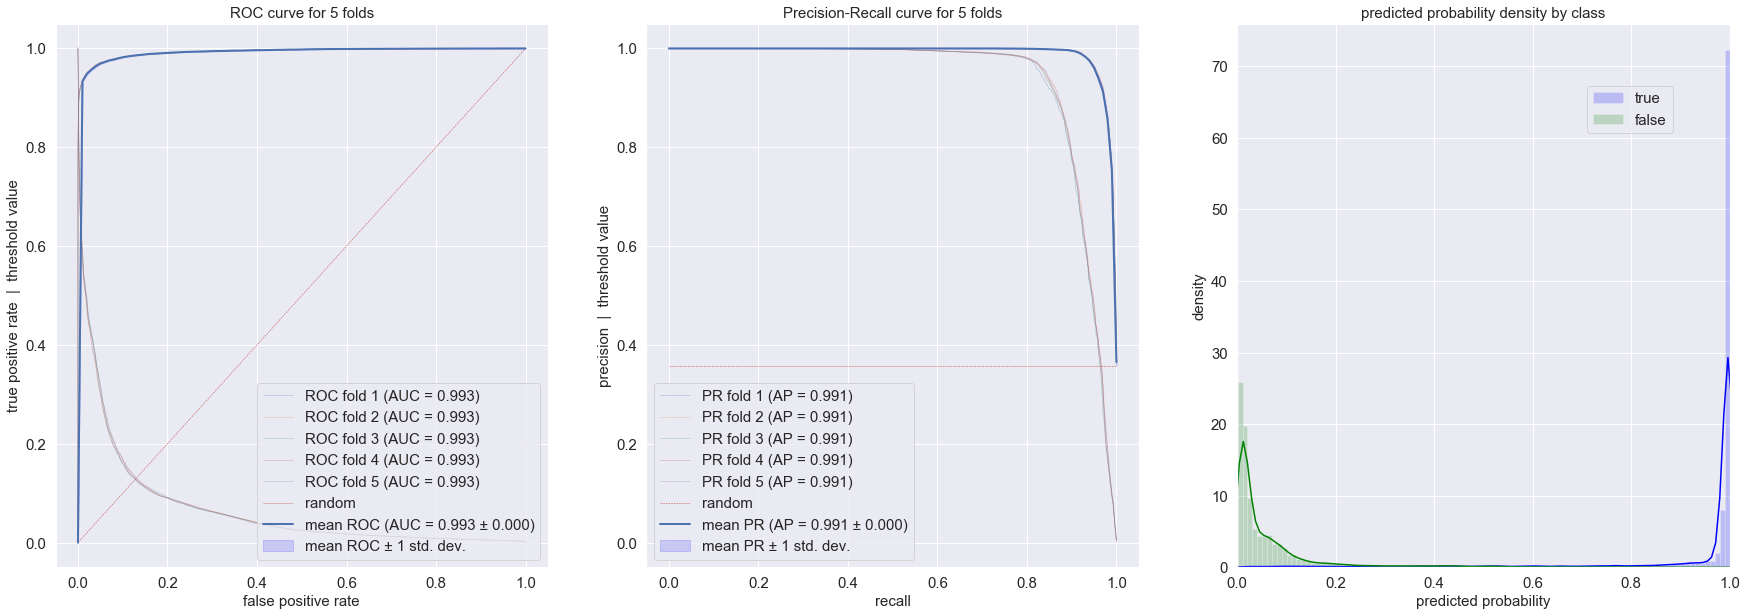

In [109]:
metrics.plot_threshold_decision_curves()

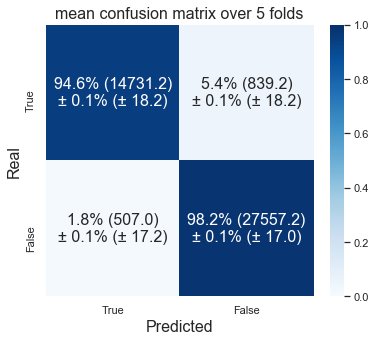

In [111]:
metrics.plot_mean_confusion_matrix()